In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from uuid import UUID

import matplotlib.pyplot as plt

import sys
sys.path.append('/Users/kshankar/e-mission/gis_branch_tests')

import emission.storage.timeseries.abstract_timeseries as esta
import emission.storage.decorations.trip_queries as esdtq
import emission.core.wrapper.user as ecwu

import confusion_matrix_handling as cm_handling
from confusion_matrix_handling import MODE_MAPPING_DICT
import get_EC
import helper_functions as hf

import sklearn.model_selection as skm
import sklearn.feature_selection as skfs
import sklearn.pipeline as skp
import sklearn.preprocessing as skpr

from sklearn.model_selection import KFold
import sklearn.linear_model as sklm
import sklearn.svm as sksvm

METERS_TO_MILES = 0.000621371 # 1 meter = 0.000621371 miles

df_EI = pd.read_csv(r'Public_Dashboard/auxiliary_files/energy_intensity.csv') # r stands for raw string, only matters if the path is on Windows

storage not configured, falling back to sample, default configuration
URL not formatted, defaulting to "Stage_database"
Connecting to database URL localhost:27018


In [2]:
import emission.core.get_database as edb

chosen_program = 'all'
all_user_list = []
programs_all = {}
for u in edb.get_uuid_db().find():         # add users to proper locations in programs 
    program = u["user_email"].split("_")[0]    # This info is in the Stage_uuids collection of the database
    uuid = u["uuid"]
    if program not in programs_all.keys(): programs_all[program] = []
    programs_all[program].append(uuid)
    all_user_list.append(uuid)

user_list = programs_all[chosen_program] if chosen_program is not 'all' else all_user_list

In [3]:
os_map = {}

for u in user_list:
    profile = ecwu.User(u).getProfile()
    if 'curr_platform' in profile:
        os_map[u] = profile['curr_platform']
    else:
        print("Removed a user who had no OS information.")
        user_list.remove(u) # Note: this removes u from programs_all[chosen_program] as well.
        no_os_user = u


Removed a user who had no OS information.


In [4]:
# Collect all trips in the program specified earlier
# Then expand user inputs.
# You could instead load the file that "place_all_trips_in_pkl.py" generates
# expanded_labeled_trips = hf.get_expanded_labeled_trips(user_list)

In [5]:
#expanded_labeled_trips.drop(['start_loc','end_loc'],axis = 1).columns

### What modes can we properly sense without substituting a "close enough" energy intensity?
drove alone, walk, bike,bus,train

In [6]:
# Base mode map for GIS. Not directly used in this notebook but nice to see.
gis_sensed_modes = {0 : 'no_sensed',    # UNKNOWN  #NOTE: this is important info to mention.
        1 : 'walking',    # WALKING
        2 : 'bicycling',    # BICYCLING
        3 : 'bus',        # BUS
        4 : 'train',      # TRAIN
        5 : 'car',        # CAR
        6 : 'air_or_hsr', # AIR_OR_HSR
        7 : 'subway',      # SUBWAY
        8 : 'train',      # TRAM
        9 : 'train',      # LIGHT_RAIL
}

# Get error related info
unit_dist_MCS_df = pd.read_csv("unit_distance_MCS.csv").set_index("moment")
#android_EI_moments_df = pd.read_csv("android_EI_moments.csv").set_index("mode")
#ios_EI_moments_df = pd.read_csv("ios_EI_moments.csv").set_index("mode")

# Dictionary of energy intensities in kWH/PMT
energy_dict = cm_handling.get_energy_dict(df_EI)
#%store -r energy_consumption_df # to save time

# sensed_car (maps via MODE_MAPPING_DICT) -> “Car, sensed” in energy dict, 
# which is used for the ground truth car intensity in get_conditional_EI_expectation_and_variance(). 
# Then the sensed mode will show car, but the EI used will be based on a car with a 1.5 person load factor.
#drove_alone_EI = energy_dict["Gas Car, drove alone"]
#load_factor = 1#1.5
#energy_dict.update({"Car, sensed": drove_alone_EI/load_factor})

In [7]:
# This dataframe was generated in place_all_trips_in_pkl.py
df = pd.read_pickle("/tmp/Sensing_sensitivity_analysis/expanded_labeled_trips.pickle")
expanded_labeled_trips = df.copy()#df[df['program'] == 'vail'].copy()

In [8]:
expanded_labeled_trips = hf.drop_unwanted_trips(expanded_labeled_trips,drop_not_a_trip=False)

expanded_labeled_trips = hf.get_primary_modes(expanded_labeled_trips,energy_dict,MODE_MAPPING_DICT)

Dropping user labeled air trips and trips with no OS.
Dropped 63 trips with no sensed sections.


In [9]:
# find out mode distance proportions for each program
program_proportions = pd.DataFrame(columns=['program','r', 'drove_alone_distance', 'shared_ride_distance','car_proportion', 'ebike_proportion', 'walk_proportion', 'drove_alone_proportion', 'shared_ride_proportion'])
for program in expanded_labeled_trips['program'].unique():
    program_df = expanded_labeled_trips[expanded_labeled_trips['program'] == program].copy()
    proportions = hf.get_ratios_for_dataset(program_df)
    proportions.update({'program': program})
    
    # Append row of proportions to the dataframe
    program_proportions = program_proportions.append(proportions, ignore_index=True)

# Get the proportions for the full dataset
proportions = hf.get_ratios_for_dataset(expanded_labeled_trips)
proportions.update({'program': 'all'})
program_proportions = program_proportions.append(proportions, ignore_index=True)

program_proportions = program_proportions.set_index("program")
#print(program_proportions.round(3).to_markdown())  # pip install tabulate
program_proportions

Distance in drove alone, shared ride (m): 8188409.7, 15963765.6
Distance in drove alone, shared ride (m): 44490725.7, 84504460.8
Distance in drove alone, shared ride (m): 13238474.4, 18557483.9
Distance in drove alone, shared ride (m): 31673372.4, 43258359.6
Distance in drove alone, shared ride (m): 11638572.9, 20566036.8
Distance in drove alone, shared ride (m): 27949845.7, 41927954.6
Distance in drove alone, shared ride (m): 6093488.3, 7312146.0
Distance in drove alone, shared ride (m): 4904180.1, 7351079.7
Distance in drove alone, shared ride (m): 148177069.3, 239441287.1


,r,drove_alone_distance,shared_ride_distance,car_proportion,ebike_proportion,walk_proportion,drove_alone_proportion,shared_ride_proportion,car_to_other,non_moto_to_moto
program,,,,,,,,,,
4c,0.512937,8.188410e+06,1.596377e+07,0.651933,0.228810,0.012215,0.221027,0.430905,1.873006,0.394911
cc,0.526490,4.449073e+07,8.450446e+07,0.658272,0.157755,0.050311,0.227040,0.431233,1.926308,0.397816
fc,0.713377,1.323847e+07,1.855748e+07,0.667793,0.181351,0.029364,0.278040,0.389753,2.010173,0.465258
pc,0.732191,3.167337e+07,4.325836e+07,0.730237,0.162096,0.016218,0.308668,0.421568,2.706953,0.357436
sc,0.565912,1.163857e+07,2.056604e+07,0.825285,0.101907,0.030144,0.298254,0.527032,4.723619,0.179651
stage,0.666616,2.794985e+07,4.192795e+07,0.775715,0.013477,0.028592,0.310272,0.465443,3.458610,0.216872
vail,0.833338,6.093488e+06,7.312146e+06,0.790535,0.055879,0.031937,0.359335,0.431200,3.774071,0.165786
prepilot,0.667137,4.904180e+06,7.351080e+06,0.571163,0.238388,0.033059,0.228562,0.342601,1.331886,0.508776
all,0.618845,1.481771e+08,2.394413e+08,0.703798,0.137833,0.033366,0.269045,0.434753,2.376075,0.340971


In [10]:
# Get the confusion matrices and then the EI moments from those.
android_confusion = pd.read_csv("android_confusion.csv").set_index('gt_mode')
ios_confusion = pd.read_csv("ios_confusion.csv").set_index('gt_mode')

r = 1  # 0.91 for vail, 0.71 for pc.
car_load_factor = (r+1)/(r+0.5)
drove_alone_EI = energy_dict["Gas Car, drove alone"]
energy_dict.update({"Car, sensed": drove_alone_EI/car_load_factor})

# if you forget this step, the error for expected may be different, 
# since you might be relying on a different saved version of the EI_moments_dataframe
android_EI_moments_df = cm_handling.get_conditional_EI_expectation_and_variance(android_confusion,energy_dict)
ios_EI_moments_df = cm_handling.get_conditional_EI_expectation_and_variance(ios_confusion,energy_dict)

energy_consumption_df = get_EC.compute_all_EC_values(expanded_labeled_trips,unit_dist_MCS_df,energy_dict,android_EI_moments_df,ios_EI_moments_df)
energy_consumption_df['distance_miles'] = energy_consumption_df.distance*METERS_TO_MILES
# %store energy_consumption_df

Computing energy consumption for each trip.
Large EC error: EC user labeled, EC expected: 330.06, 216.60
	Trip info: mode_confirm,sensed,distance (mi): ('bus', ['walking', 'car', 'walking', 'car', 'bicycling', 'car', 'car', 'bicycling', 'car', 'walking']),228.18
Large EC error: EC user labeled, EC expected: 0.00, 101.24
	Trip info: mode_confirm,sensed,distance (mi): ('skateboard', ['car', 'car', 'walking', 'car', 'walking', 'car', 'walking']),99.02
Large EC error: EC user labeled, EC expected: 271.94, 170.27
	Trip info: mode_confirm,sensed,distance (mi): ('drove_alone', ['car', 'walking', 'car', 'walking', 'car', 'car', 'walking', 'car', 'walking']),165.82
Large EC error: EC user labeled, EC expected: 220.13, 345.64
	Trip info: mode_confirm,sensed,distance (mi): ('shared_ride', ['car']),277.82
Large EC error: EC user labeled, EC expected: 315.14, 494.82
	Trip info: mode_confirm,sensed,distance (mi): ('shared_ride', ['car']),397.73
Large EC error: EC user labeled, EC expected: 180.43, 2

In [11]:
r = 1
car_EI_load_divider = (r+1)/(r+0.5)  # aka Michael's definition of load factor.
drove_alone_EI = energy_dict["Gas Car, drove alone"]
energy_dict.update({"Car, sensed": drove_alone_EI/car_EI_load_divider})
program_df = expanded_labeled_trips[expanded_labeled_trips['program'] == '4c'].copy()


EC_4c = get_EC.compute_all_EC_values(program_df,unit_dist_MCS_df,energy_dict,android_EI_moments_df,ios_EI_moments_df)

Computing energy consumption for each trip.
Large EC error: EC user labeled, EC expected: 330.06, 216.60
	Trip info: mode_confirm,sensed,distance (mi): ('bus', ['walking', 'car', 'walking', 'car', 'bicycling', 'car', 'car', 'bicycling', 'car', 'walking']),228.18
Large EC error: EC user labeled, EC expected: 0.00, 101.24
	Trip info: mode_confirm,sensed,distance (mi): ('skateboard', ['car', 'car', 'walking', 'car', 'walking', 'car', 'walking']),99.02
Large EC error: EC user labeled, EC expected: 271.94, 170.27
	Trip info: mode_confirm,sensed,distance (mi): ('drove_alone', ['car', 'walking', 'car', 'walking', 'car', 'car', 'walking', 'car', 'walking']),165.82
Total EC: expected, predicted, user labeled: 17461.18, 18644.17, 18791.19
standard deviation for expected: 363.58
Percent errors for expected and for predicted, including outliers: -7.08, -0.78


In [12]:
program_df = energy_consumption_df[energy_consumption_df['program'] == '4c'].copy()

#### Most recent update:
May want to look at primary mode normalized by distance rather than value counts.

In [13]:
all_trip_modes = expanded_labeled_trips[['mode_confirm','section_modes','primary_mode']].copy()

#for i,ct in all_trip_modes.iterrows():

for mode in ['drove_alone','shared_ride','walk','pilot_ebike','bus','bike']:
    #n_user_labels = all_trip_modes['mode_confirm'].count(mode)
    mode_df = all_trip_modes[all_trip_modes['mode_confirm'] == mode]
    section_mode_distance_dict_given_user_label = {}
    for i,ct in mode_df.iterrows():
        section_modes = ct['section_modes']

    print(mode)
    print(mode_df.primary_mode.value_counts(normalize=True))

drove_alone
car           0.797655
walking       0.134342
no_sensed     0.038790
bicycling     0.019221
bus           0.009437
air_or_hsr    0.000555
Name: primary_mode, dtype: float64
shared_ride
car           0.785938
walking       0.140765
no_sensed     0.037395
bicycling     0.024669
bus           0.009740
train         0.000853
air_or_hsr    0.000640
Name: primary_mode, dtype: float64
walk
walking       0.866052
car           0.076301
bicycling     0.033262
no_sensed     0.018654
bus           0.004270
air_or_hsr    0.001236
train         0.000225
Name: primary_mode, dtype: float64
pilot_ebike
bicycling     0.342317
walking       0.318277
car           0.297526
no_sensed     0.036629
bus           0.004049
train         0.000759
air_or_hsr    0.000443
Name: primary_mode, dtype: float64
bus
car          0.559633
walking      0.320267
bicycling    0.055880
no_sensed    0.033361
bus          0.025855
train        0.005004
Name: primary_mode, dtype: float64
bike
bicycling    0.592890


In [14]:
drove_alone_4c_df = program_df[program_df['mode_confirm'] == 'drove_alone']
drove_alone_outliers = hf.get_outliers(drove_alone_4c_df,'error_for_confusion',100,15)[['distance','mode_confirm','section_modes','section_distances','primary_mode','primary_length','error_for_confusion','error_for_prediction','expected','predicted', 'user_labeled','os']]
#drove_alone_outliers

100.00 and 15.00 percentiles: -0.03,-17.93


100.00 and 15.00 percentiles: 84.77,-2.36
85.00 and 0.00 percentiles: 3.70,-81.93


Text(0.5, 1.0, '4c shared ride underestimates primary modes(below 15th percentile)')

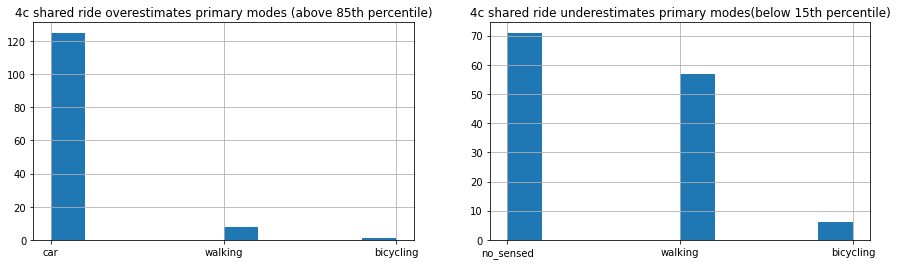

In [15]:
shared_ride_4c_df = program_df[program_df['mode_confirm'] == 'shared_ride']
shared_ride_outliers_low = hf.get_outliers(shared_ride_4c_df,'error_for_confusion',100,15)[['distance','distance_miles','mode_confirm','section_modes','section_distances','primary_mode','primary_length','error_for_confusion','error_for_prediction','expected','predicted', 'user_labeled','os']]
shared_ride_outliers_high = hf.get_outliers(shared_ride_4c_df,'error_for_confusion',85,0)[['distance','distance_miles','mode_confirm','section_modes','section_distances','primary_mode','primary_length','error_for_confusion','error_for_prediction','expected','predicted', 'user_labeled','os']]

fig,axs = plt.subplots(1,2)
fig.set_figwidth(15)
shared_ride_outliers_high.primary_mode.hist(ax = axs[0])
shared_ride_outliers_low.primary_mode.hist(ax = axs[1])

axs[0].set_title("4c shared ride overestimates primary modes (above 85th percentile)")
axs[1].set_title("4c shared ride underestimates primary modes(below 15th percentile)")

# most of the overestimates are car. (blue)
# most of the unerestimates are walking, bicycling, and no sensed.

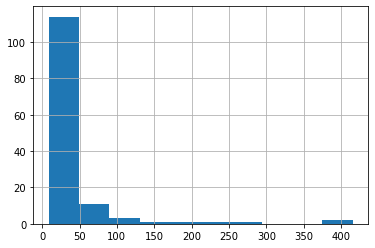

In [16]:
shared_ride_outliers_high.distance_miles.hist()

Text(0.5, 1.0, '4c drove alone outlier primary modes (below the 15th percentile)')

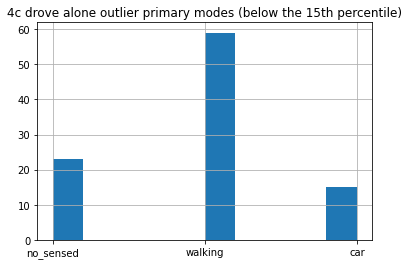

In [17]:
drove_alone_outliers.primary_mode.hist()
plt.title("4c drove alone outlier primary modes (below the 15th percentile)")

In [18]:
# Naming convenction below: <user label>_<primary mode>
drove_alone_car = drove_alone_4c_df[drove_alone_4c_df.primary_mode == 'car']
shared_ride_car = shared_ride_4c_df[shared_ride_4c_df.primary_mode == 'car']

EI_used_for_android_sensed_car = 1.189540
EI_used_for_android_walking = 0.010464
EI_for_drove_alone = 1.51517707
EI_for_shared_ride = 0.757588535
drove_alone_car_distance = drove_alone_car.distance.sum()*METERS_TO_MILES
shared_ride_car_distance = shared_ride_car.distance.sum()*METERS_TO_MILES

# the outliers below 15% account for -2390 kWH
drove_alone_outlier_error = drove_alone_outliers.error_for_confusion.sum()
shared_ride_outliers_high_error = shared_ride_outliers_high.error_for_confusion.sum()
shared_ride_outliers_low_error = shared_ride_outliers_low.error_for_confusion.sum()

# the drove alone trips in 4c where the primary mode is car account for -1754 kWH of error.
print(f"Errors for drove alone and shared ride when we predict car: {drove_alone_car.error_for_confusion.sum():.2f}, {shared_ride_car.error_for_confusion.sum():.2f}")
print(f"Drove alone outlier errors sum: {drove_alone_outlier_error:.2f}")
print(f"Shared ride outlier error for upper outliers, lower outliers: {shared_ride_outliers_high_error:.2f}, {shared_ride_outliers_low_error:.2f}")

print("\nMost of the outlier error for drove alone is from walking.")
print(f"Difference between sensed walking and drove alone EI: {EI_used_for_android_walking - EI_for_drove_alone:.4f}")

print("\nMost of the overestimation outlier error for shared ride is from sensed car.")
print(f"Difference between sensed car and shared ride EI: {EI_used_for_android_sensed_car - EI_for_shared_ride:.4f}")

print("\nMost of the underestimation outlier error for shared ride is from no_sensed and walking.")
print(f"Difference between no_sensed and shared ride EI: {android_EI_moments_df['mean(EI)']['no_sensed'] - EI_for_shared_ride:.4f}")
print(f"Difference between sensed walking and shared ride EI: {EI_used_for_android_walking - EI_for_shared_ride:.4f}")
print("In either case, when we mispredict drove alone, we are guaranteed to have a higher error than for a similar shared ride trip.")


Errors for drove alone and shared ride when we predict car: -1754.35, 1844.29
Drove alone outlier errors sum: -2390.67
Shared ride outlier error for upper outliers, lower outliers: 1222.49, -1423.92

Most of the outlier error for drove alone is from walking.
Difference between sensed walking and drove alone EI: -1.5047

Most of the overestimation outlier error for shared ride is from sensed car.
Difference between sensed car and shared ride EI: 0.4320

Most of the underestimation outlier error for shared ride is from no_sensed and walking.
Difference between no_sensed and shared ride EI: -0.6709
Difference between sensed walking and shared ride EI: -0.7471
In either case, when we mispredict drove alone, we are guaranteed to have a higher error than for a similar shared ride trip.


In [19]:
#%store -r energy_consumption_df

### Modeling the energy consumption percent error as a function of dataset characteristics
Make sure you've calculated program proportions and energy consumption for the full dataset first.
Before analysis, keep track of whether you dropped not a trips in the "helper_functions.drop_unwanted_trips()" call. 

### Plot energy consumption by user labeled mode

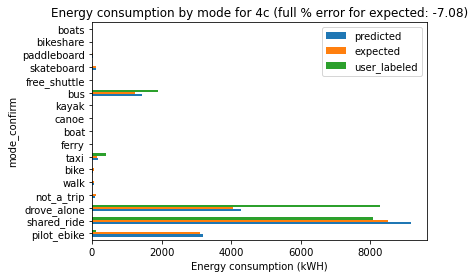

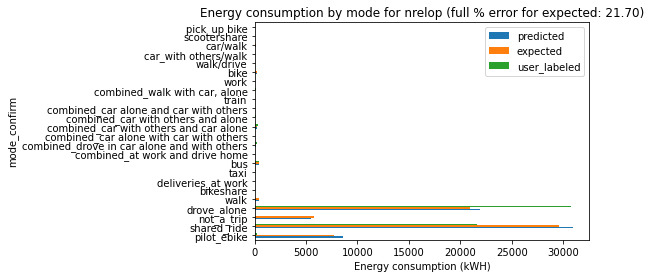

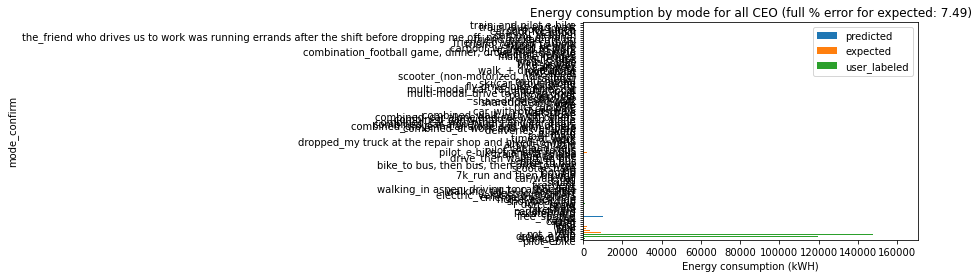

In [20]:
program_df = energy_consumption_df[energy_consumption_df['program'] == '4c'].copy()

hf.plot_energy_consumption_by_mode(program_df,'4c')
hf.plot_energy_consumption_by_mode(energy_consumption_df[energy_consumption_df['program'] == 'pc'].copy(),'nrelop')
hf.plot_energy_consumption_by_mode(energy_consumption_df,'all CEO')

In [21]:
(energy_consumption_df.query('program == "pc" & mode_confirm == "train"').error_for_confusion.sum(),
 energy_consumption_df.query('program == "pc" & mode_confirm == "bus"').error_for_confusion.sum(),
 energy_consumption_df.query('program == "pc" & mode_confirm == "shared_ride"').error_for_confusion.sum(),
 energy_consumption_df.query('program == "pc" & mode_confirm == "e_car_shared_ride"').error_for_confusion.sum(),
 energy_consumption_df.query('program == "pc" & mode_confirm == "pilot_ebike"').error_for_confusion.sum(),
 energy_consumption_df.query('program == "pc" & mode_confirm == "drove_alone"').error_for_confusion.sum(),
 energy_consumption_df.query('program == "pc"').error_for_confusion.sum(),
 energy_consumption_df.query('program == "pc"').expected.sum(),
 energy_consumption_df.query('program == "pc"').user_labeled.sum()
)

(0.5827505729147471,
 -60.8550046782422,
 7970.9515208245275,
 0.0,
 7446.588036155588,
 -9855.398447118978,
 11741.268536869276,
 65859.19246033693,
 54117.92392346764)

In [22]:
energy_consumption_df.query('program == "4c"').groupby("mode_confirm").sum().error_for_confusion.abs().sort_values().tail(n=10)

mode_confirm
paddleboard      19.341575
bike             47.771291
walk             69.744893
skateboard      110.185198
not_a_trip      111.330550
taxi            247.155601
shared_ride     436.376970
bus             668.351633
pilot_ebike    2984.670495
drove_alone    4238.796766
Name: error_for_confusion, dtype: float64

In [23]:
energy_consumption_df.query('program == "pc"').groupby("mode_confirm").sum().error_for_confusion.abs().sort_values().tail(n=10)

mode_confirm
combined_car with others and car alone           77.467201
combined_drove in car alone and with others      77.493681
taxi                                             84.844248
car/walk                                         94.751563
bike                                            213.661764
walk                                            462.292602
not_a_trip                                     5733.516583
pilot_ebike                                    7446.588036
shared_ride                                    7970.951521
drove_alone                                    9855.398447
Name: error_for_confusion, dtype: float64

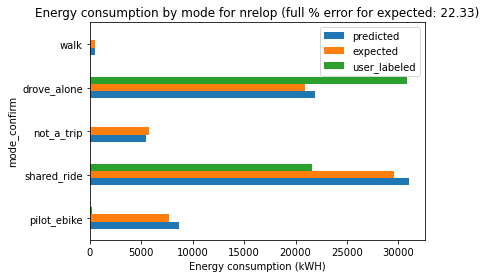

In [24]:
hf.plot_energy_consumption_by_mode(energy_consumption_df[energy_consumption_df['program'] == 'pc'].query('mode_confirm == ["drove_alone", "shared_ride", "pilot_ebike", "not_a_trip", "walk"]').copy(),'nrelop')

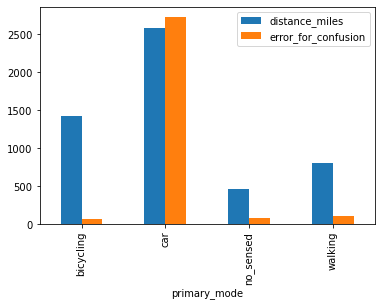

In [25]:
energy_consumption_df.query('program == "4c" & mode_confirm == "pilot_ebike"').groupby('primary_mode').sum()[["distance_miles", "error_for_confusion"]].plot(kind="bar")

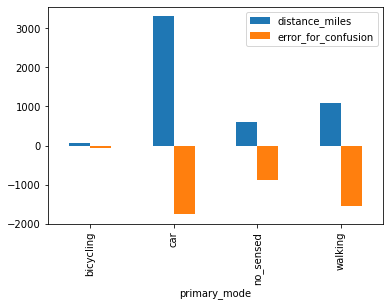

In [26]:
energy_consumption_df.query('program == "4c" & mode_confirm == "drove_alone"').groupby('primary_mode').sum()[["distance_miles", "error_for_confusion"]].plot(kind="bar")

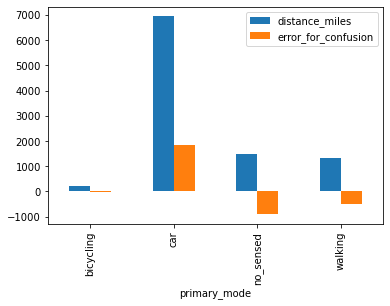

In [27]:
energy_consumption_df.query('program == "4c" & mode_confirm == "shared_ride"').groupby('primary_mode').sum()[["distance_miles", "error_for_confusion"]].plot(kind="bar")

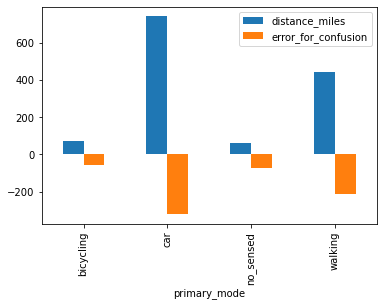

In [28]:
energy_consumption_df.query('program == "4c" & mode_confirm == "bus"').groupby('primary_mode').sum()[["distance_miles", "error_for_confusion"]].plot(kind="bar")

In [29]:
energy_consumption_df.query('program == "4c" & (mode_confirm == "shared_ride" | mode_confirm == "drove_alone")').groupby('primary_mode').sum()[["distance_miles", "error_for_confusion"]], energy_consumption_df.query('program == "4c" & mode_confirm == "pilot_ebike"').groupby('primary_mode').sum()[["distance_miles", "error_for_confusion"]]

(              distance_miles  error_for_confusion
 primary_mode                                     
 bicycling         270.861260           -88.566918
 car             10239.579751            89.933542
 no_sensed        2086.059847         -1770.501213
 walking          2410.960466         -2033.285206,
               distance_miles  error_for_confusion
 primary_mode                                     
 bicycling        1417.553302            72.147265
 car              2578.580267          2729.936714
 no_sensed         461.966187            80.621929
 walking           809.098421           101.964587)

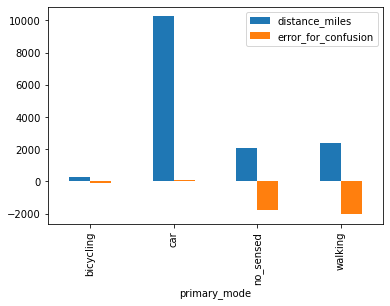

In [30]:
energy_consumption_df.query('program == "4c" & (mode_confirm == "shared_ride" | mode_confirm == "drove_alone")').groupby('primary_mode').sum()[["distance_miles", "error_for_confusion"]].plot(kind="bar")

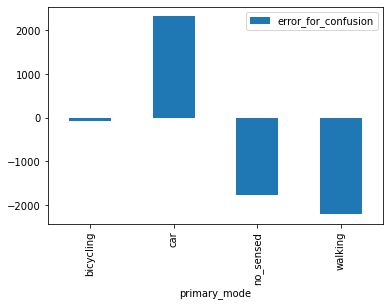

In [31]:
big_error_modes = ['drove_alone', 'pilot_ebike', 'bus', 'shared_ride', 'taxi']
energy_consumption_df.query('program == "4c" & mode_confirm == @big_error_modes').groupby('primary_mode').sum()[["error_for_confusion"]].plot(kind="bar")

In [32]:
energy_consumption_df.query('program == "4c"').error_for_confusion.sum(), energy_consumption_df.query('program == "4c"').user_labeled.sum() 

(-1330.0124285903926, 18791.19086436768)

### Splitting into separate sets to check for variations

We are now going to try and see if we can determine the source of the variation across programs.

Here are the features that we plan to try
- drove_alone_2_shared_ride
- no_sensed_ratio
- not_a_trip_ratio
- e_bike_ratio
- car_like_ratio
- car_like_as_not_car
- e_bike_as_car
- e_bike_as_not_bike
- car_to_non_car_motorized_user_label
- car_to_non_car_motorized_sensed
- mispredicted_as_walk
- mispredicted_as_car

First, let's take the data we have now and split it into 10 parts with shuffling to create 10 fake distributions and see what happens to the error calculations

In [33]:
# splitting without shuffling leads to some larger car to other ratios
kf = KFold(n_splits=10, shuffle=True, random_state=2)  # some splits might not have any ebike

# The naive KFold gives us 10 separate arrays with 4283 train and 476 test trips
# But what we really want is 9 training sets of trips (to simulate the 9 programs for training)
# and one test set of trips 
# Note that our features are for sets of trips, not individual trips
for train_index, test_index in kf.split(energy_consumption_df):
    print(len(train_index), len(test_index))

54019 6003
54019 6003
54020 6002
54020 6002
54020 6002
54020 6002
54020 6002
54020 6002
54020 6002
54020 6002


In [34]:
# There are multiple crossvalidation splitters in sklearn but all of them split into one training and one test set at a time
# if we want to split into k-1 training sets and k test sets, we are gonna have to do it ourselves
# New code suggestion from https://numpy.org/doc/stable/reference/random/generated/numpy.random.shuffle.html
def get_set_splits(n_rounds = 50, n_splits_per_round=10):
    from numpy.random import default_rng
    large_size_splits = []
    for round in range(n_rounds):
        rng = default_rng()
        trip_index = np.array(energy_consumption_df.index.copy())
        rng.shuffle(trip_index)
        # print(energy_consumption_df.index, trip_index)
        splits = np.array_split(trip_index, n_splits_per_round)
        large_size_splits.append(splits)
    large_size_splits = np.array(large_size_splits).flatten()
    print([len(s) for s in large_size_splits])
    return large_size_splits

In [35]:
energy_consumption_df.columns

Index(['duration', 'distance', 'start_place', 'end_place', 'cleaned_trip',
       'inferred_labels', 'inferred_trip', 'expectation',
       'confidence_threshold', 'expected_trip', 'user_input', 'section_modes',
       'section_distances', '_id', 'user_id', 'metadata_write_ts',
       'mode_confirm', 'purpose_confirm', 'replaced_mode', 'os', 'program',
       'primary_mode', 'primary_length', 'error_for_confusion',
       'error_for_prediction', 'expected', 'predicted', 'user_labeled',
       'confusion_var', 'user_var', 'confusion_sd', 'user_sd',
       'distance_miles'],
      dtype='object')

### First round and splitting and plotting the splits

In [36]:
splits = get_set_splits(n_rounds = 50, n_splits_per_round=10)
split_result_list = []
for s in splits:
    ERROR_COLS = ['error_for_confusion',
       'error_for_prediction', 'expected', 'predicted', 'user_labeled', 'distance_miles', 'distance', 'duration']
    curr_split_result = {'count': len(s)}
    for e in ERROR_COLS:
        curr_split_result[e] = energy_consumption_df.loc[s][e].sum()
    # print(curr_split_result)
    # print(f"CHECK user_labeled {energy_consumption_df.loc[s].user_labeled.sum()}")
    # print(f"CHECK error_for_confusion {energy_consumption_df.loc[s].error_for_confusion.sum()}")
    split_result_list.append(curr_split_result)
split_results = pd.DataFrame(split_result_list)
split_results

[6003, 6003, 6002, 6002, 6002, 6002, 6002, 6002, 6002, 6002, 6003, 6003, 6002, 6002, 6002, 6002, 6002, 6002, 6002, 6002, 6003, 6003, 6002, 6002, 6002, 6002, 6002, 6002, 6002, 6002, 6003, 6003, 6002, 6002, 6002, 6002, 6002, 6002, 6002, 6002, 6003, 6003, 6002, 6002, 6002, 6002, 6002, 6002, 6002, 6002, 6003, 6003, 6002, 6002, 6002, 6002, 6002, 6002, 6002, 6002, 6003, 6003, 6002, 6002, 6002, 6002, 6002, 6002, 6002, 6002, 6003, 6003, 6002, 6002, 6002, 6002, 6002, 6002, 6002, 6002, 6003, 6003, 6002, 6002, 6002, 6002, 6002, 6002, 6002, 6002, 6003, 6003, 6002, 6002, 6002, 6002, 6002, 6002, 6002, 6002, 6003, 6003, 6002, 6002, 6002, 6002, 6002, 6002, 6002, 6002, 6003, 6003, 6002, 6002, 6002, 6002, 6002, 6002, 6002, 6002, 6003, 6003, 6002, 6002, 6002, 6002, 6002, 6002, 6002, 6002, 6003, 6003, 6002, 6002, 6002, 6002, 6002, 6002, 6002, 6002, 6003, 6003, 6002, 6002, 6002, 6002, 6002, 6002, 6002, 6002, 6003, 6003, 6002, 6002, 6002, 6002, 6002, 6002, 6002, 6002, 6003, 6003, 6002, 6002, 6002, 6002, 600

/Users/kshankar/miniconda-4.8.3/envs/emission-private-eval/lib/python3.7/site-packages/ipykernel_launcher.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


,count,error_for_confusion,error_for_prediction,expected,predicted,user_labeled,distance_miles,distance,duration
0,6003,2023.525095,3724.416031,28722.413090,30423.304025,26698.887994,31343.442517,5.044240e+07,9.985841e+06
1,6003,3552.203647,5087.482513,32709.619561,34244.898427,29157.415914,35525.074760,5.717208e+07,9.811514e+06
2,6002,1813.077896,3718.737126,31804.946917,33710.606147,29991.869021,34270.679961,5.515333e+07,9.847706e+06
3,6002,2493.745799,3729.673888,32993.096588,34229.024677,30499.350790,35097.568280,5.648408e+07,1.027363e+07
4,6002,2314.386663,3906.116644,29465.922046,31057.652026,27151.535383,33034.950482,5.316462e+07,1.077932e+07
...,...,...,...,...,...,...,...,...,...
495,6002,2022.523767,3415.244312,31592.006953,32984.727498,29569.483186,34581.181011,5.565303e+07,1.066504e+07
496,6002,1670.831316,3133.087699,28553.145497,30015.401879,26882.314180,30930.610725,4.977801e+07,9.621112e+06
497,6002,1442.590673,3209.707553,29019.986218,30787.103098,27577.395545,31601.879093,5.085831e+07,1.003100e+07
498,6002,2882.769158,4564.248058,33393.832752,35075.311652,30511.063594,37718.953837,6.070279e+07,1.023218e+07


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8903250090>,
      dtype=object)

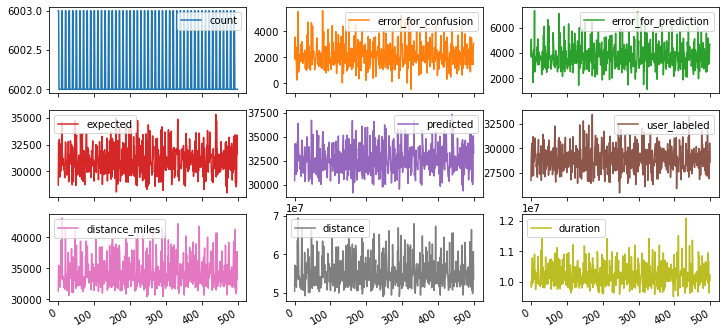

In [37]:
split_results.plot(subplots=True, layout=(3,3), figsize=(12,6))

In [38]:
split_results['error_pct_for_confusion'] = (split_results.error_for_confusion / split_results.user_labeled ) * 100
split_results['error_pct_for_prediction'] = (split_results.error_for_prediction / split_results.user_labeled) * 100

In [39]:
split_results

,count,error_for_confusion,error_for_prediction,expected,predicted,user_labeled,distance_miles,distance,duration,error_pct_for_confusion,error_pct_for_prediction
0,6003,2023.525095,3724.416031,28722.413090,30423.304025,26698.887994,31343.442517,5.044240e+07,9.985841e+06,7.579061,13.949705
1,6003,3552.203647,5087.482513,32709.619561,34244.898427,29157.415914,35525.074760,5.717208e+07,9.811514e+06,12.182848,17.448331
2,6002,1813.077896,3718.737126,31804.946917,33710.606147,29991.869021,34270.679961,5.515333e+07,9.847706e+06,6.045231,12.399151
3,6002,2493.745799,3729.673888,32993.096588,34229.024677,30499.350790,35097.568280,5.648408e+07,1.027363e+07,8.176390,12.228699
4,6002,2314.386663,3906.116644,29465.922046,31057.652026,27151.535383,33034.950482,5.316462e+07,1.077932e+07,8.523962,14.386356
...,...,...,...,...,...,...,...,...,...,...,...
495,6002,2022.523767,3415.244312,31592.006953,32984.727498,29569.483186,34581.181011,5.565303e+07,1.066504e+07,6.839902,11.549895
496,6002,1670.831316,3133.087699,28553.145497,30015.401879,26882.314180,30930.610725,4.977801e+07,9.621112e+06,6.215355,11.654829
497,6002,1442.590673,3209.707553,29019.986218,30787.103098,27577.395545,31601.879093,5.085831e+07,1.003100e+07,5.231062,11.638907
498,6002,2882.769158,4564.248058,33393.832752,35075.311652,30511.063594,37718.953837,6.070279e+07,1.023218e+07,9.448275,14.959321


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8934ddf150>,
      dtype=object)

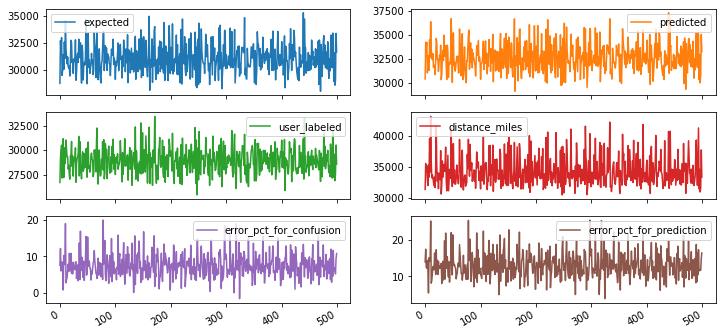

In [40]:
split_results[["expected", "predicted", "user_labeled", "distance_miles", "error_pct_for_confusion", "error_pct_for_prediction"]].plot(subplots=True, layout=(3,2), figsize=(12,6))

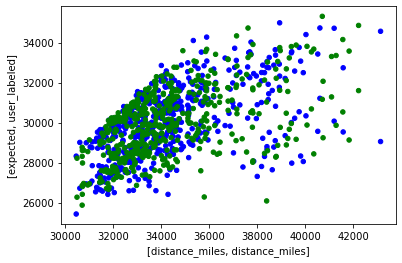

In [41]:
ax = split_results.plot.scatter(x=["distance_miles", "distance_miles"], y=["expected", "user_labeled"], c=['blue'] * 500 + ['green'] * 500)

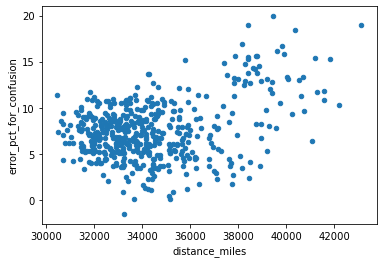

In [42]:
ax = split_results.plot.scatter(x="distance_miles", y="error_pct_for_confusion")

### Recomputing with the potential other factors

In [43]:
# Recomputing with the other potential factors
def get_split_results(splits):
    CAR_LIKE_MODES = ['drove_alone', 'shared_ride', 'taxi']
    NON_CAR_MOTORIZED_MODES = ['bus', 'free_shuttle', 'train']
    split_result_list = []
    for s in splits:
        ERROR_COLS = ['error_for_confusion',
           'error_for_prediction', 'expected', 'predicted', 'user_labeled', 'distance_miles', 'distance', 'duration']
        curr_split_trips = energy_consumption_df.loc[s]
        curr_split_result = {'count': len(s)}
        for e in ERROR_COLS:
            curr_split_result[e] = curr_split_trips[e].sum()
        curr_split_result['drove_alone_2_shared_ride'] = curr_split_trips.query('mode_confirm == "drove_alone"').distance.sum() / curr_split_trips.query('mode_confirm == "shared_ride"').distance.sum()
        curr_split_result['no_sensed_ratio'] = curr_split_trips.query('primary_mode == "no_sensed"').distance.sum() / curr_split_trips.distance.sum()
        curr_split_result['car_like_ratio'] = curr_split_trips.query('mode_confirm == @CAR_LIKE_MODES').distance.sum() / curr_split_trips.distance.sum()        
        curr_split_result['e_bike_ratio'] = curr_split_trips.query('mode_confirm == "pilot_ebike"').distance.sum() / curr_split_trips.distance.sum()
        curr_split_result['not_a_trip_ratio'] = curr_split_trips.query('mode_confirm == "not_a_trip"').distance.sum() / curr_split_trips.distance.sum()
        
        curr_split_result['car_like_as_not_car'] = curr_split_trips.query('mode_confirm == @CAR_LIKE_MODES & primary_mode != "car"').distance.sum() / curr_split_trips.query('mode_confirm == @CAR_LIKE_MODES').distance.sum()
        curr_split_result['e_bike_as_car'] = curr_split_trips.query('mode_confirm == "pilot_ebike" & primary_mode == "car"').distance.sum() / curr_split_trips.query('mode_confirm == "pilot_ebike"').distance.sum()
        curr_split_result['e_bike_as_not_car_bike'] = curr_split_trips.query('mode_confirm == "pilot_ebike" & primary_mode != ["car", "bicycling"]').distance.sum() / curr_split_trips.query('mode_confirm == "pilot_ebike"').distance.sum()

        curr_split_result['non_car_2_car_user_label'] = curr_split_trips.query('mode_confirm == @NON_CAR_MOTORIZED_MODES').distance.sum() / curr_split_trips.query('mode_confirm == @CAR_LIKE_MODES').distance.sum()
        curr_split_result['non_car_2_car_sensed'] = curr_split_trips.query('primary_mode == ["bus", "train"]').distance.sum() / curr_split_trips.query('primary_mode == "car"').distance.sum()
        curr_split_result['mispredicted_as_walk'] = curr_split_trips.query('mode_confirm != "walk" & primary_mode == "walking"').distance.sum() / curr_split_trips.distance.sum()
        curr_split_result['mispredicted_as_car'] = curr_split_trips.query('mode_confirm != @CAR_LIKE_MODES & primary_mode == "car"').distance.sum() / curr_split_trips.distance.sum()
    
        # if curr_split_result['drove_alone_2_shared_ride'] > 0.5:
            # print(f"CHECK: drove_alone %s, shared_ride %s" % (curr_split_trips.query('mode_confirm == "drove_alone"').distance_miles.sum(),
            #                                                   curr_split_trips.query('mode_confirm == "shared_ride"').distance_miles.sum()))
        # print(curr_split_result)
        # print(f"CHECK user_labeled {energy_consumption_df.loc[s].user_labeled.sum()}")
        # print(f"CHECK error_for_confusion {energy_consumption_df.loc[s].error_for_confusion.sum()}")
        split_result_list.append(curr_split_result)
    split_results = pd.DataFrame(split_result_list)
    split_results['error_pct_for_confusion'] = (split_results.error_for_confusion / split_results.user_labeled ) * 100
    split_results['error_pct_for_prediction'] = (split_results.error_for_prediction / split_results.user_labeled) * 100
    return split_results

split_results = get_split_results(splits)

In [44]:
split_results[["non_car_2_car_sensed", "non_car_2_car_user_label"]]

,non_car_2_car_sensed,non_car_2_car_user_label
0,0.011974,0.043330
1,0.006098,0.062277
2,0.009596,0.051983
3,0.007701,0.041895
4,0.007008,0.047174
...,...,...
495,0.008732,0.042761
496,0.016505,0.076938
497,0.008626,0.060347
498,0.007376,0.043386


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8943294950>,
      dtype=object)

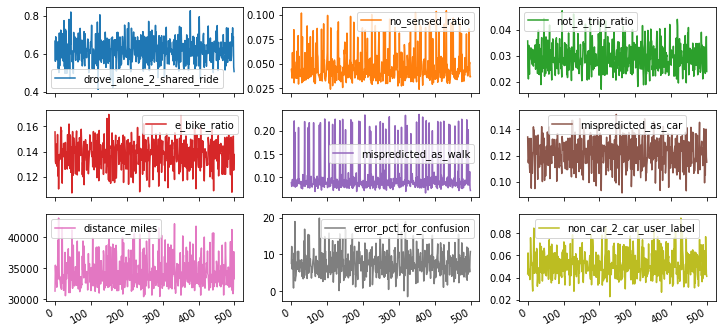

In [45]:
split_results[['drove_alone_2_shared_ride', 'no_sensed_ratio', 'not_a_trip_ratio', "e_bike_ratio", "mispredicted_as_walk", "mispredicted_as_car", "distance_miles", "error_pct_for_confusion", "non_car_2_car_user_label"]].plot(subplots=True, layout=(3,3), figsize=(12,6))

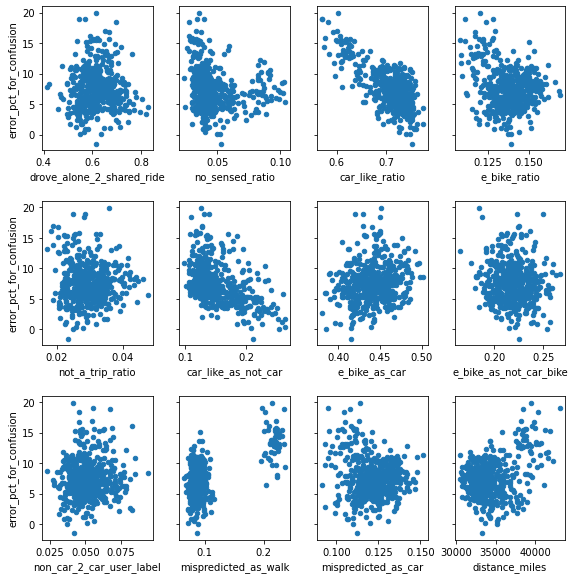

In [46]:
fig, ax2d = plt.subplots(nrows=3, ncols=4, figsize=(8,8), sharey=True)
fig.tight_layout(h_pad = 3)
axarray = ax2d.flatten()
IND_VAR = ['drove_alone_2_shared_ride', 'no_sensed_ratio', 'car_like_ratio', 'e_bike_ratio', 'not_a_trip_ratio',
           "car_like_as_not_car", "e_bike_as_car", "e_bike_as_not_car_bike", 
           "non_car_2_car_user_label", "mispredicted_as_walk", "mispredicted_as_car", 'distance_miles']
DEP_VAR = 'error_pct_for_confusion'
for iv, ax in zip(IND_VAR, axarray):
    split_results.plot(x=iv, y=DEP_VAR, ax=ax, kind="scatter")

### Feature estimation

In [47]:
estimators = pd.Series({"linear": sklm.LinearRegression(), "lasso": sklm.Lasso(), "ridge": sklm.Ridge(),
                       "bayesian": sklm.ARDRegression(), "sgd": sklm.SGDRegressor(),
                        "svm_linear": sksvm.SVR(kernel="linear"), "NuSVR": sksvm.NuSVR(kernel="linear")})
std_estimators = estimators.apply(lambda e: skp.Pipeline([("scale", skpr.StandardScaler()), ("reg", e)]))
selectors = std_estimators.apply(lambda e: skfs.RFECV(e, step=1, importance_getter="named_steps.reg.coef_"))
fitted_selectors = selectors.apply(lambda s: s.fit(split_results[IND_VAR], split_results[DEP_VAR]))

In [48]:
estimator_sel_features = pd.DataFrame.from_records(fitted_selectors.apply(lambda fs: np.array(IND_VAR)[fs.support_]), index=fitted_selectors.index); estimator_sel_features

,0,1,2,3,4,5,6,7,8,9,10,11
linear,drove_alone_2_shared_ride,no_sensed_ratio,car_like_ratio,e_bike_ratio,not_a_trip_ratio,car_like_as_not_car,e_bike_as_car,e_bike_as_not_car_bike,non_car_2_car_user_label,mispredicted_as_walk,mispredicted_as_car,distance_miles
lasso,car_like_ratio,car_like_as_not_car,mispredicted_as_walk,None,None,None,None,None,None,None,None,None
ridge,drove_alone_2_shared_ride,no_sensed_ratio,car_like_ratio,e_bike_ratio,not_a_trip_ratio,car_like_as_not_car,e_bike_as_car,e_bike_as_not_car_bike,non_car_2_car_user_label,mispredicted_as_walk,mispredicted_as_car,distance_miles
bayesian,drove_alone_2_shared_ride,no_sensed_ratio,car_like_ratio,e_bike_ratio,not_a_trip_ratio,car_like_as_not_car,e_bike_as_car,non_car_2_car_user_label,mispredicted_as_walk,mispredicted_as_car,None,None
sgd,drove_alone_2_shared_ride,no_sensed_ratio,car_like_ratio,e_bike_ratio,not_a_trip_ratio,car_like_as_not_car,e_bike_as_car,non_car_2_car_user_label,mispredicted_as_walk,mispredicted_as_car,distance_miles,None
svm_linear,drove_alone_2_shared_ride,no_sensed_ratio,car_like_ratio,e_bike_ratio,not_a_trip_ratio,car_like_as_not_car,e_bike_as_car,e_bike_as_not_car_bike,non_car_2_car_user_label,mispredicted_as_walk,mispredicted_as_car,distance_miles
NuSVR,drove_alone_2_shared_ride,no_sensed_ratio,car_like_ratio,e_bike_ratio,not_a_trip_ratio,car_like_as_not_car,e_bike_as_car,non_car_2_car_user_label,mispredicted_as_walk,mispredicted_as_car,distance_miles,None


(['drove_alone_2_shared_ride',
  'no_sensed_ratio',
  'car_like_ratio',
  'e_bike_ratio',
  'not_a_trip_ratio',
  'car_like_as_not_car',
  'e_bike_as_car',
  'e_bike_as_not_car_bike',
  'non_car_2_car_user_label',
  'mispredicted_as_walk',
  'mispredicted_as_car',
  'distance_miles'],
 <matplotlib.axes._subplots.AxesSubplot at 0x7f88e48e4d90>)

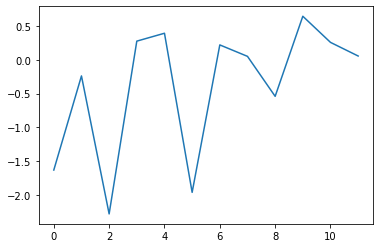

In [49]:
IND_VAR, pd.Series(fitted_selectors.loc['linear'].estimator_['reg'].coef_).plot()

In [50]:
estimator_grid_scores = pd.DataFrame.from_records(fitted_selectors.apply(lambda fs: fs.grid_scores_), index=fitted_selectors.index); estimator_grid_scores

,0,1,2,3,4,5,6,7,8,9,10,11
linear,0.480977,0.639604,0.801390,0.821610,0.833104,0.863250,0.873901,0.875128,0.877045,0.881903,0.883058,0.883121
lasso,0.390717,0.468516,0.472770,0.472770,0.472770,0.472770,0.472770,0.472770,0.472770,0.472770,0.472770,0.472770
ridge,0.481026,0.639638,0.801384,0.821639,0.833190,0.863297,0.873937,0.875129,0.877033,0.881883,0.883094,0.883165
bayesian,0.480996,0.639581,0.801376,0.821525,0.833239,0.863817,0.873894,0.875270,0.879075,0.883292,0.883180,0.883186
sgd,0.480867,0.639633,0.801364,0.821845,0.837320,0.868320,0.873298,0.872622,0.875291,0.880532,0.882801,0.882583
svm_linear,0.476559,0.636459,0.799884,0.817278,0.832224,0.869866,0.876926,0.877104,0.877843,0.880977,0.881950,0.882661
NuSVR,0.483954,0.632096,0.800254,0.820886,0.826113,0.866601,0.873808,0.873833,0.874944,0.879961,0.882406,0.881512


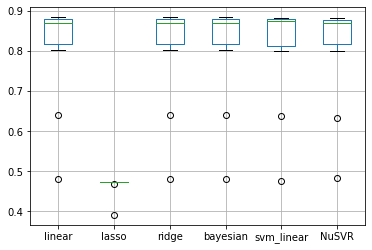

In [51]:
estimator_grid_scores.transpose().drop(columns=['sgd']).plot(kind="box", grid=True)

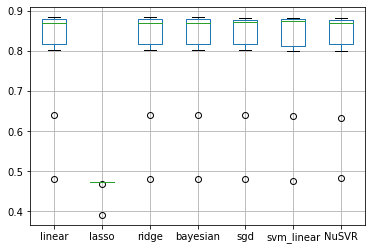

In [52]:
estimator_grid_scores.transpose().plot(kind="box", grid=True)

In [53]:
estimator_grid_scores.transpose().median()

linear        0.868575
lasso         0.472770
ridge         0.868617
bayesian      0.868856
sgd           0.870471
svm_linear    0.873396
NuSVR         0.870204
dtype: float64

In [54]:
np.array(IND_VAR)[skfs.SelectPercentile(skfs.f_regression, percentile=0.9).fit(split_results[IND_VAR], split_results[DEP_VAR]).get_support()]

array(['car_like_ratio'], dtype='<U25')

In [55]:
np.array(IND_VAR)[skfs.SelectPercentile(skfs.mutual_info_regression, percentile=0.9).fit(split_results[IND_VAR], split_results[DEP_VAR]).get_support()]

array(['car_like_ratio'], dtype='<U25')

In [56]:
expanded_labeled_trips.mode_confirm.value_counts(normalize=True)

pilot_ebike                           0.264809
drove_alone                           0.241423
shared_ride                           0.235643
walk                                  0.149082
not_a_trip                            0.038816
                                        ...   
friend_carpool to work                0.000017
7k_run and then brunch                0.000017
pilot_e-bike to bus                   0.000017
multi-modal_drive to bike to drive    0.000017
ride                                  0.000017
Name: mode_confirm, Length: 106, dtype: float64

### Figuring out how to represent feature selection results across multiple runs

- each run may result in a separate set of selected features
- we first determine the support (aka included/not) values for each feature
- we convert them to numbers
- we add the the numbers
- if we divide by the numer of interations, then the closeness to 2 will indicate how often the feature was selected

In [57]:
true_false_df = pd.DataFrame.from_records(fitted_selectors.apply(lambda fs: fs.support_), index=fitted_selectors.index, columns=IND_VAR); true_false_df

,drove_alone_2_shared_ride,no_sensed_ratio,car_like_ratio,e_bike_ratio,not_a_trip_ratio,car_like_as_not_car,e_bike_as_car,e_bike_as_not_car_bike,non_car_2_car_user_label,mispredicted_as_walk,mispredicted_as_car,distance_miles
linear,True,True,True,True,True,True,True,True,True,True,True,True
lasso,False,False,True,False,False,True,False,False,False,True,False,False
ridge,True,True,True,True,True,True,True,True,True,True,True,True
bayesian,True,True,True,True,True,True,True,False,True,True,True,False
sgd,True,True,True,True,True,True,True,False,True,True,True,True
svm_linear,True,True,True,True,True,True,True,True,True,True,True,True
NuSVR,True,True,True,True,True,True,True,False,True,True,True,True


In [58]:
int_feature_df = true_false_df.applymap(lambda tf: int(tf)); int_feature_df

,drove_alone_2_shared_ride,no_sensed_ratio,car_like_ratio,e_bike_ratio,not_a_trip_ratio,car_like_as_not_car,e_bike_as_car,e_bike_as_not_car_bike,non_car_2_car_user_label,mispredicted_as_walk,mispredicted_as_car,distance_miles
linear,1,1,1,1,1,1,1,1,1,1,1,1
lasso,0,0,1,0,0,1,0,0,0,1,0,0
ridge,1,1,1,1,1,1,1,1,1,1,1,1
bayesian,1,1,1,1,1,1,1,0,1,1,1,0
sgd,1,1,1,1,1,1,1,0,1,1,1,1
svm_linear,1,1,1,1,1,1,1,1,1,1,1,1
NuSVR,1,1,1,1,1,1,1,0,1,1,1,1


In [59]:
int_feature_df + int_feature_df

,drove_alone_2_shared_ride,no_sensed_ratio,car_like_ratio,e_bike_ratio,not_a_trip_ratio,car_like_as_not_car,e_bike_as_car,e_bike_as_not_car_bike,non_car_2_car_user_label,mispredicted_as_walk,mispredicted_as_car,distance_miles
linear,2,2,2,2,2,2,2,2,2,2,2,2
lasso,0,0,2,0,0,2,0,0,0,2,0,0
ridge,2,2,2,2,2,2,2,2,2,2,2,2
bayesian,2,2,2,2,2,2,2,0,2,2,2,0
sgd,2,2,2,2,2,2,2,0,2,2,2,2
svm_linear,2,2,2,2,2,2,2,2,2,2,2,2
NuSVR,2,2,2,2,2,2,2,0,2,2,2,2


### Figuring out how to represent scores across runs

- each run will result in 6 scores per estimator
- we can create a dataframe where the columns are the estimators and the rows are the scores
- for each run, we just append the scores to the dataframe and then reset the index

In [60]:
estimator_grid_scores.transpose().append(estimator_grid_scores.transpose()).reset_index(drop=True)

,linear,lasso,ridge,bayesian,sgd,svm_linear,NuSVR
0,0.480977,0.390717,0.481026,0.480996,0.480867,0.476559,0.483954
1,0.639604,0.468516,0.639638,0.639581,0.639633,0.636459,0.632096
2,0.801390,0.472770,0.801384,0.801376,0.801364,0.799884,0.800254
3,0.821610,0.472770,0.821639,0.821525,0.821845,0.817278,0.820886
4,0.833104,0.472770,0.833190,0.833239,0.837320,0.832224,0.826113
5,0.863250,0.472770,0.863297,0.863817,0.868320,0.869866,0.866601
6,0.873901,0.472770,0.873937,0.873894,0.873298,0.876926,0.873808
7,0.875128,0.472770,0.875129,0.875270,0.872622,0.877104,0.873833
8,0.877045,0.472770,0.877033,0.879075,0.875291,0.877843,0.874944
9,0.881903,0.472770,0.881883,0.883292,0.880532,0.880977,0.879961


### Figuring out how to represent coefficients across runs

For each run, we will presumably get the coefficients for only the last run. For the algorithms with stable results, this won't matter. We can have the rows as the algorithms and the columns as the features or vice versa, but we will need to have multiple rows, one for each run.

Let's have the columns be the features, and the rows be the algo, run combinations.

Some complications:
- the SVM coefficients are in a 2-D array, but we can flatten them
- we only get coeffiecients for the features that are meaningful?

```
drove_alone_2_shared_ride 	no_sensed_ratio 	not_a_trip_ratio 	e_bike_ratio 	mispredicted_as_walk 	mispredicted_as_car 	distance_miles

linear 	True 	True 	True 	False 	True 	True 	False
linear 	-1.765813e+01 	-5.202422e+01 	99.113221 	124.429262 	46.013267 	NaN

or 

sgd 	True 	False 	False 	False 	False 	False 	True
sgd 	-2.047909e+10 	-7.597053e+10 	NaN 	NaN 	NaN 	NaN

or

svm_linear 	True 	True 	True 	True 	False 	True 	False
svm_linear 	-1.449385e+01 	-6.055291e+00 	4.868629 	6.639475 	9.626487 	NaN
```

So we need to find the support, find the dicts by zipping and then create the dataframe

In [61]:
# fitted_selectors['linear'].estimator_.coef_, np.pad(fitted_selectors['linear'].estimator_.coef_.copy(), (0,len(IND_VAR) - len(fitted_selectors['linear'].estimator_.coef_)), 'constant')

In [62]:
fitted_selectors['svm_linear'].estimator_['reg'].coef_, np.pad(fitted_selectors['linear'].estimator_['reg'].coef_.copy(), (0,len(IND_VAR) - len(fitted_selectors['linear'].estimator_['reg'].coef_)), 'constant')

(array([[-1.6550782 , -0.23088112, -2.3461298 ,  0.200607  ,  0.31763127,
         -1.98737717,  0.18913177,  0.07706066, -0.51482439,  0.55303   ,
          0.33188089,  0.11208423]]),
 array([-1.63400096, -0.23942979, -2.28391585,  0.27597531,  0.3929355 ,
        -1.96448729,  0.22011544,  0.05048963, -0.54160642,  0.64481229,
         0.25763053,  0.05561022]))

In [63]:
fitted_selectors.apply(lambda fs: fs.estimator_['reg'].coef_.flatten())

linear        [-1.634000955190931, -0.23942979136054476, -2....
lasso         [-1.157225025843155, -0.3895676042206098, 0.08...
ridge         [-1.6231094759588076, -0.2383704547766053, -2....
bayesian      [-1.6332997098985926, -0.2282132389746629, -2....
sgd           [-1.610977672263247, -0.2200082084341883, -2.1...
svm_linear    [-1.655078201987036, -0.23088112298323749, -2....
NuSVR         [-1.666956693110327, -0.25619555125320737, -2....
dtype: object

In [64]:
pd.DataFrame.from_records(fitted_selectors.apply(lambda fs: fs.estimator_['reg'].coef_.flatten()), index=fitted_selectors.index)

,0,1,2,3,4,5,6,7,8,9,10,11
linear,-1.634001,-0.239430,-2.283916,0.275975,0.392936,-1.964487,0.220115,0.050490,-0.541606,0.644812,0.257631,0.055610
lasso,-1.157225,-0.389568,0.080182,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ridge,-1.623109,-0.238370,-2.267481,0.277337,0.391797,-1.959495,0.219830,0.049334,-0.537213,0.649183,0.255935,0.064030
bayesian,-1.633300,-0.228213,-2.297380,0.243061,0.388059,-1.956520,0.191020,-0.536174,0.645994,0.246910,NaN,NaN
sgd,-1.610978,-0.220008,-2.162249,0.363985,0.402465,-1.993193,0.173447,-0.527981,0.697921,0.257857,0.192269,NaN
svm_linear,-1.655078,-0.230881,-2.346130,0.200607,0.317631,-1.987377,0.189132,0.077061,-0.514824,0.553030,0.331881,0.112084
NuSVR,-1.666957,-0.256196,-2.257704,0.325517,0.414848,-1.981694,0.171426,-0.538401,0.633131,0.283418,0.131626,NaN


In [65]:
list(zip(np.array(IND_VAR)[fitted_selectors['svm_linear'].support_],fitted_selectors['svm_linear'].estimator_['reg'].coef_.flatten()))

[('drove_alone_2_shared_ride', -1.655078201987036),
 ('no_sensed_ratio', -0.23088112298323749),
 ('car_like_ratio', -2.3461298042750265),
 ('e_bike_ratio', 0.2006069980027223),
 ('not_a_trip_ratio', 0.31763126834334054),
 ('car_like_as_not_car', -1.9873771710333663),
 ('e_bike_as_car', 0.18913177498398737),
 ('e_bike_as_not_car_bike', 0.07706066304645709),
 ('non_car_2_car_user_label', -0.5148243899081306),
 ('mispredicted_as_walk', 0.553029996103197),
 ('mispredicted_as_car', 0.3318808926194978),
 ('distance_miles', 0.11208423460826245)]

In [66]:
estimator_coef = pd.DataFrame.from_records(fitted_selectors.apply(lambda fs: dict(zip(np.array(IND_VAR)[fs.support_], fs.estimator_['reg'].coef_.flatten()))), index=fitted_selectors.index); estimator_coef

,drove_alone_2_shared_ride,no_sensed_ratio,car_like_ratio,e_bike_ratio,not_a_trip_ratio,car_like_as_not_car,e_bike_as_car,e_bike_as_not_car_bike,non_car_2_car_user_label,mispredicted_as_walk,mispredicted_as_car,distance_miles
linear,-1.634001,-0.239430,-2.283916,0.275975,0.392936,-1.964487,0.220115,0.050490,-0.541606,0.644812,0.257631,0.055610
lasso,NaN,NaN,-1.157225,NaN,NaN,-0.389568,NaN,NaN,NaN,0.080182,NaN,NaN
ridge,-1.623109,-0.238370,-2.267481,0.277337,0.391797,-1.959495,0.219830,0.049334,-0.537213,0.649183,0.255935,0.064030
bayesian,-1.633300,-0.228213,-2.297380,0.243061,0.388059,-1.956520,0.191020,NaN,-0.536174,0.645994,0.246910,NaN
sgd,-1.610978,-0.220008,-2.162249,0.363985,0.402465,-1.993193,0.173447,NaN,-0.527981,0.697921,0.257857,0.192269
svm_linear,-1.655078,-0.230881,-2.346130,0.200607,0.317631,-1.987377,0.189132,0.077061,-0.514824,0.553030,0.331881,0.112084
NuSVR,-1.666957,-0.256196,-2.257704,0.325517,0.414848,-1.981694,0.171426,NaN,-0.538401,0.633131,0.283418,0.131626


In [67]:
estimator_coef['run'] = [1] * len(estimator_coef); estimator_coef

,drove_alone_2_shared_ride,no_sensed_ratio,car_like_ratio,e_bike_ratio,not_a_trip_ratio,car_like_as_not_car,e_bike_as_car,e_bike_as_not_car_bike,non_car_2_car_user_label,mispredicted_as_walk,mispredicted_as_car,distance_miles,run
linear,-1.634001,-0.239430,-2.283916,0.275975,0.392936,-1.964487,0.220115,0.050490,-0.541606,0.644812,0.257631,0.055610,1
lasso,NaN,NaN,-1.157225,NaN,NaN,-0.389568,NaN,NaN,NaN,0.080182,NaN,NaN,1
ridge,-1.623109,-0.238370,-2.267481,0.277337,0.391797,-1.959495,0.219830,0.049334,-0.537213,0.649183,0.255935,0.064030,1
bayesian,-1.633300,-0.228213,-2.297380,0.243061,0.388059,-1.956520,0.191020,NaN,-0.536174,0.645994,0.246910,NaN,1
sgd,-1.610978,-0.220008,-2.162249,0.363985,0.402465,-1.993193,0.173447,NaN,-0.527981,0.697921,0.257857,0.192269,1
svm_linear,-1.655078,-0.230881,-2.346130,0.200607,0.317631,-1.987377,0.189132,0.077061,-0.514824,0.553030,0.331881,0.112084,1
NuSVR,-1.666957,-0.256196,-2.257704,0.325517,0.414848,-1.981694,0.171426,NaN,-0.538401,0.633131,0.283418,0.131626,1


/Users/kshankar/miniconda-4.8.3/envs/emission-private-eval/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


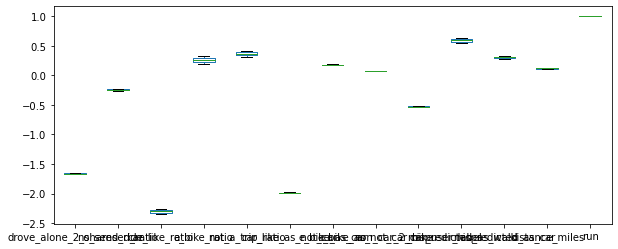

In [68]:
estimator_coef.loc[['svm_linear', 'NuSVR']].plot(kind="box", figsize=(10,4))

## Figured it all out, starting the runs now

In [69]:
# Creating the splits first just in case we want to do something standard with them
# TODO: Set a random seed

split_reps = []
for repetition in range(10):
    splits = get_set_splits(n_rounds=50, n_splits_per_round=10)
    split_reps.append(splits)

/Users/kshankar/miniconda-4.8.3/envs/emission-private-eval/lib/python3.7/site-packages/ipykernel_launcher.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


[6003, 6003, 6002, 6002, 6002, 6002, 6002, 6002, 6002, 6002, 6003, 6003, 6002, 6002, 6002, 6002, 6002, 6002, 6002, 6002, 6003, 6003, 6002, 6002, 6002, 6002, 6002, 6002, 6002, 6002, 6003, 6003, 6002, 6002, 6002, 6002, 6002, 6002, 6002, 6002, 6003, 6003, 6002, 6002, 6002, 6002, 6002, 6002, 6002, 6002, 6003, 6003, 6002, 6002, 6002, 6002, 6002, 6002, 6002, 6002, 6003, 6003, 6002, 6002, 6002, 6002, 6002, 6002, 6002, 6002, 6003, 6003, 6002, 6002, 6002, 6002, 6002, 6002, 6002, 6002, 6003, 6003, 6002, 6002, 6002, 6002, 6002, 6002, 6002, 6002, 6003, 6003, 6002, 6002, 6002, 6002, 6002, 6002, 6002, 6002, 6003, 6003, 6002, 6002, 6002, 6002, 6002, 6002, 6002, 6002, 6003, 6003, 6002, 6002, 6002, 6002, 6002, 6002, 6002, 6002, 6003, 6003, 6002, 6002, 6002, 6002, 6002, 6002, 6002, 6002, 6003, 6003, 6002, 6002, 6002, 6002, 6002, 6002, 6002, 6002, 6003, 6003, 6002, 6002, 6002, 6002, 6002, 6002, 6002, 6002, 6003, 6003, 6002, 6002, 6002, 6002, 6002, 6002, 6002, 6002, 6003, 6003, 6002, 6002, 6002, 6002, 600

[6003, 6003, 6002, 6002, 6002, 6002, 6002, 6002, 6002, 6002, 6003, 6003, 6002, 6002, 6002, 6002, 6002, 6002, 6002, 6002, 6003, 6003, 6002, 6002, 6002, 6002, 6002, 6002, 6002, 6002, 6003, 6003, 6002, 6002, 6002, 6002, 6002, 6002, 6002, 6002, 6003, 6003, 6002, 6002, 6002, 6002, 6002, 6002, 6002, 6002, 6003, 6003, 6002, 6002, 6002, 6002, 6002, 6002, 6002, 6002, 6003, 6003, 6002, 6002, 6002, 6002, 6002, 6002, 6002, 6002, 6003, 6003, 6002, 6002, 6002, 6002, 6002, 6002, 6002, 6002, 6003, 6003, 6002, 6002, 6002, 6002, 6002, 6002, 6002, 6002, 6003, 6003, 6002, 6002, 6002, 6002, 6002, 6002, 6002, 6002, 6003, 6003, 6002, 6002, 6002, 6002, 6002, 6002, 6002, 6002, 6003, 6003, 6002, 6002, 6002, 6002, 6002, 6002, 6002, 6002, 6003, 6003, 6002, 6002, 6002, 6002, 6002, 6002, 6002, 6002, 6003, 6003, 6002, 6002, 6002, 6002, 6002, 6002, 6002, 6002, 6003, 6003, 6002, 6002, 6002, 6002, 6002, 6002, 6002, 6002, 6003, 6003, 6002, 6002, 6002, 6002, 6002, 6002, 6002, 6002, 6003, 6003, 6002, 6002, 6002, 6002, 600

In [70]:
for run in range(10):
    for run_2 in range(run, 10):
        print(f"Comparing {run} and {run_2}")
        if np.array_equal(split_reps[run][0], split_reps[run_2][0]):
            print(f"CHECK: split indices at index 0 for {run} and {run_2} are the same!")

Comparing 0 and 0
CHECK: split indices at index 0 for 0 and 0 are the same!
Comparing 0 and 1
Comparing 0 and 2
Comparing 0 and 3
Comparing 0 and 4
Comparing 0 and 5
Comparing 0 and 6
Comparing 0 and 7
Comparing 0 and 8
Comparing 0 and 9
Comparing 1 and 1
CHECK: split indices at index 0 for 1 and 1 are the same!
Comparing 1 and 2
Comparing 1 and 3
Comparing 1 and 4
Comparing 1 and 5
Comparing 1 and 6
Comparing 1 and 7
Comparing 1 and 8
Comparing 1 and 9
Comparing 2 and 2
CHECK: split indices at index 0 for 2 and 2 are the same!
Comparing 2 and 3
Comparing 2 and 4
Comparing 2 and 5
Comparing 2 and 6
Comparing 2 and 7
Comparing 2 and 8
Comparing 2 and 9
Comparing 3 and 3
CHECK: split indices at index 0 for 3 and 3 are the same!
Comparing 3 and 4
Comparing 3 and 5
Comparing 3 and 6
Comparing 3 and 7
Comparing 3 and 8
Comparing 3 and 9
Comparing 4 and 4
CHECK: split indices at index 0 for 4 and 4 are the same!
Comparing 4 and 5
Comparing 4 and 6
Comparing 4 and 7
Comparing 4 and 8
Comparin

In [71]:

all_int_feature_df = None
all_estimator_grid_scores = None
all_estimator_coef = None

for run, splits in enumerate(split_reps):
    # Get the split
    print(f"Running run {run} with {len(splits)} size")
    split_results = get_split_results(splits)
    
    # Creating new estimators and selectors
    estimators = pd.Series({"linear": sklm.LinearRegression(), "ridge": sklm.Ridge(),
                "bayesian": sklm.ARDRegression(),
                "svm_linear": sksvm.SVR(kernel="linear")})
    print(f"Created new estimators {len(estimators)}")
    std_estimators = estimators.apply(lambda e: skp.Pipeline([("scale", skpr.StandardScaler()), ("reg", e)]))
    print(f"After combining with the pipeline {len(std_estimators)} ")
    selectors = std_estimators.apply(lambda e: skfs.RFECV(e, step=1, importance_getter="named_steps.reg.coef_"))
    print("Created selectors, about to fit them")

    
    # Fit the selectors
    fitted_selectors = selectors.apply(lambda s: s.fit(split_results[IND_VAR], split_results[DEP_VAR]))
    print("Finished fitting selectors, about to generate results")
    
    # Combine the feature selection
    curr_true_false_df = pd.DataFrame.from_records(fitted_selectors.apply(lambda fs: fs.support_), index=fitted_selectors.index, columns=IND_VAR)
    curr_int_feature_df = curr_true_false_df.applymap(lambda tf: int(tf))
    all_int_feature_df = curr_int_feature_df if all_int_feature_df is None else all_int_feature_df + curr_int_feature_df

    # Combine the grid scores
    curr_estimator_grid_scores = pd.DataFrame.from_records(fitted_selectors.apply(lambda fs: fs.grid_scores_), index=fitted_selectors.index).transpose()
    curr_estimator_grid_scores['run'] = [run] * len(curr_estimator_grid_scores)
    all_estimator_grid_scores = curr_estimator_grid_scores if all_estimator_grid_scores is None else all_estimator_grid_scores.append(curr_estimator_grid_scores)
    
    # Combine the coefficients
    curr_estimator_coef = pd.DataFrame.from_records(fitted_selectors.apply(lambda fs: dict(zip(np.array(IND_VAR)[fs.support_], fs.estimator_['reg'].coef_.flatten()))), index=fitted_selectors.index)
    curr_estimator_coef['run'] = [run] * len(curr_estimator_coef)
    all_estimator_coef = curr_estimator_coef if all_estimator_coef is None else all_estimator_coef.append(curr_estimator_coef)

Running run 0 with 500 size
Created new estimators 4
After combining with the pipeline 4 
Created selectors, about to fit them
Finished fitting selectors, about to generate results
Running run 1 with 500 size
Created new estimators 4
After combining with the pipeline 4 
Created selectors, about to fit them
Finished fitting selectors, about to generate results
Running run 2 with 500 size
Created new estimators 4
After combining with the pipeline 4 
Created selectors, about to fit them
Finished fitting selectors, about to generate results
Running run 3 with 500 size
Created new estimators 4
After combining with the pipeline 4 
Created selectors, about to fit them
Finished fitting selectors, about to generate results
Running run 4 with 500 size
Created new estimators 4
After combining with the pipeline 4 
Created selectors, about to fit them
Finished fitting selectors, about to generate results
Running run 5 with 500 size
Created new estimators 4
After combining with the pipeline 4 
Creat

In [72]:
all_int_feature_df

,drove_alone_2_shared_ride,no_sensed_ratio,car_like_ratio,e_bike_ratio,not_a_trip_ratio,car_like_as_not_car,e_bike_as_car,e_bike_as_not_car_bike,non_car_2_car_user_label,mispredicted_as_walk,mispredicted_as_car,distance_miles
linear,10,9,10,9,10,10,10,9,10,10,10,10
ridge,10,9,10,9,10,10,10,9,10,10,10,10
bayesian,10,9,10,8,10,10,10,4,10,10,10,7
svm_linear,10,10,10,9,9,10,10,4,10,10,10,8


In [73]:
(all_int_feature_df/10).mean()

drove_alone_2_shared_ride    1.000
no_sensed_ratio              0.925
car_like_ratio               1.000
e_bike_ratio                 0.875
not_a_trip_ratio             0.975
car_like_as_not_car          1.000
e_bike_as_car                1.000
e_bike_as_not_car_bike       0.650
non_car_2_car_user_label     1.000
mispredicted_as_walk         1.000
mispredicted_as_car          1.000
distance_miles               0.875
dtype: float64

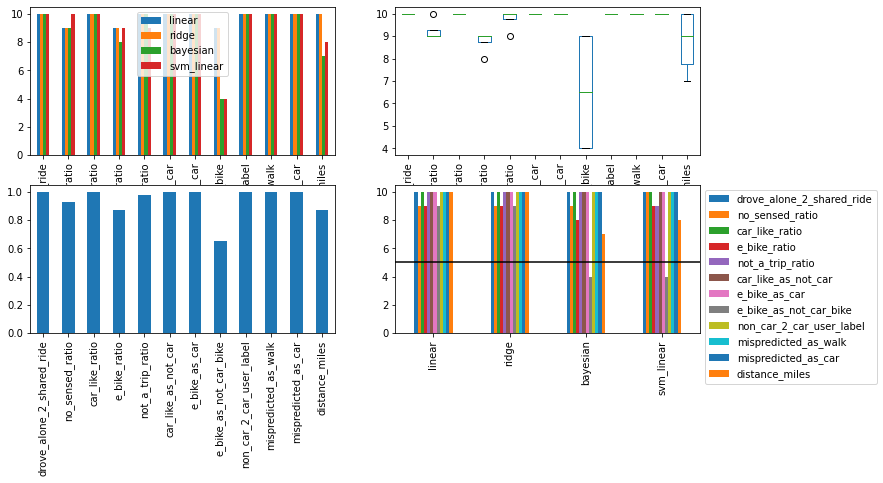

In [74]:
fig, ax = plt.subplots(nrows=2, ncols=2, squeeze=True, figsize=(12,6))
all_int_feature_df.transpose().plot(kind="bar", ax=ax[0][0])
all_int_feature_df.plot(kind="box", ax=ax[0][1], rot=90)
(all_int_feature_df/10).mean().plot(kind="bar", ax=ax[1][0])
all_int_feature_df.plot(kind="bar", ax=ax[1][1])
ax[1][1].hlines(y=5,xmin=-1,xmax=len(all_int_feature_df))
ax[1][1].legend(bbox_to_anchor=(1, 1))

### We get three sets of feature selections

- Only 10: drove_alone_2_shared_ride, car_like_ratio, car_like_as_not_car, e_bike_as_car, non_car_2_car_user_label, mispredicted_as_walk
- All over 50%: drop e_bike_as_not_car_bike, distance_miles
- Everything

In [75]:
all_estimator_grid_scores.reset_index(inplace=True, drop=True)

In [76]:
all_estimator_grid_scores

,linear,ridge,bayesian,svm_linear,run
0,0.604596,0.604614,0.604603,0.604787,0
1,0.710424,0.710446,0.710440,0.709276,0
2,0.822474,0.822516,0.822492,0.822114,0
3,0.841274,0.841309,0.841284,0.840311,0
4,0.859228,0.859237,0.859222,0.859239,0
...,...,...,...,...,...
115,0.887366,0.887374,0.890781,0.884835,9
116,0.889283,0.889283,0.889823,0.885859,9
117,0.891224,0.891233,0.891785,0.889040,9
118,0.892536,0.892573,0.892272,0.890857,9


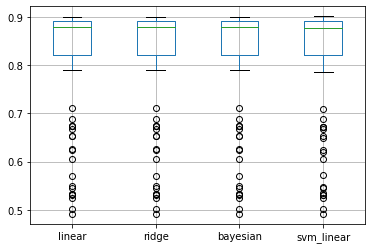

In [77]:
all_estimator_grid_scores.drop(columns='run').plot(kind="box", grid=True)

In [78]:
all_estimator_coef

,drove_alone_2_shared_ride,no_sensed_ratio,car_like_ratio,e_bike_ratio,not_a_trip_ratio,car_like_as_not_car,e_bike_as_car,e_bike_as_not_car_bike,non_car_2_car_user_label,mispredicted_as_walk,mispredicted_as_car,distance_miles,run
linear,-1.559196,-0.127566,-2.309942,0.300645,0.216640,-1.886645,0.297883,0.077264,-0.563878,0.826394,0.374749,0.051577,0
ridge,-1.548556,-0.126067,-2.294246,0.305379,0.218280,-1.881747,0.296491,0.074185,-0.559140,0.830800,0.371044,0.062164,0
bayesian,-1.560555,-0.102398,-2.310114,0.277038,0.202342,-1.871957,0.246879,NaN,-0.562293,0.845838,0.371007,NaN,0
svm_linear,-1.558631,-0.077330,-2.250583,0.336582,0.227322,-1.896096,0.225436,0.069803,-0.554629,0.841139,0.340926,0.085677,0
linear,-1.663403,-0.182576,-2.314758,0.217775,0.363343,-1.839820,0.303595,0.101253,-0.669635,0.829662,0.341109,-0.089912,1
ridge,-1.653243,-0.180673,-2.297119,0.220366,0.363718,-1.836711,0.301592,0.099630,-0.664259,0.834575,0.340547,-0.077712,1
bayesian,-1.641512,-0.156802,-2.270581,0.237438,0.348342,-1.851926,0.208014,NaN,-0.667133,0.826254,0.380563,NaN,1
svm_linear,-1.626217,-0.214681,-2.261774,0.188466,0.324899,-1.846205,0.300877,0.172403,-0.691935,0.857685,0.445772,NaN,1
linear,-1.544391,-0.116206,-2.106647,0.240254,0.377672,-1.779984,0.273983,0.070879,-0.549846,1.010741,0.240541,-0.239286,2
ridge,-1.535266,-0.115895,-2.094085,0.245193,0.379047,-1.775848,0.272325,0.069284,-0.545882,1.012910,0.238724,-0.226881,2


In [79]:
all_estimator_coef.loc[["svm_linear"]]

,drove_alone_2_shared_ride,no_sensed_ratio,car_like_ratio,e_bike_ratio,not_a_trip_ratio,car_like_as_not_car,e_bike_as_car,e_bike_as_not_car_bike,non_car_2_car_user_label,mispredicted_as_walk,mispredicted_as_car,distance_miles,run
svm_linear,-1.558631,-0.077330,-2.250583,0.336582,0.227322,-1.896096,0.225436,0.069803,-0.554629,0.841139,0.340926,0.085677,0
svm_linear,-1.626217,-0.214681,-2.261774,0.188466,0.324899,-1.846205,0.300877,0.172403,-0.691935,0.857685,0.445772,NaN,1
svm_linear,-1.533102,-0.072729,-2.067504,0.259792,0.455206,-1.762034,0.246477,NaN,-0.559168,1.041162,0.169420,-0.224926,2
svm_linear,-1.696744,-0.142373,-2.461242,0.067275,0.282238,-1.801768,0.274268,NaN,-0.489011,0.853517,0.198440,-0.443060,3
svm_linear,-1.754804,-0.052925,-2.348725,0.249148,0.399329,-1.931340,0.150611,NaN,-0.508921,0.829072,0.291798,-0.032179,4
svm_linear,-1.661193,-0.182813,-2.440883,0.191946,0.330207,-1.706688,0.300229,0.062715,-0.615136,0.705341,0.280931,-0.188410,5
svm_linear,-1.605912,-0.090833,-2.201107,0.391332,0.173946,-1.995439,0.084989,-0.087403,-0.598259,0.827644,0.524612,0.158907,6
svm_linear,-1.706005,-0.303790,-2.376534,NaN,NaN,-2.009653,0.259970,NaN,-0.573559,0.813121,0.526595,-0.320394,7
svm_linear,-1.551352,-0.178143,-2.394579,0.142688,0.353817,-1.904269,0.208420,NaN,-0.583654,0.581027,0.409474,NaN,8
svm_linear,-1.558898,-0.194474,-2.146242,0.303888,0.384561,-1.920212,0.193979,NaN,-0.545987,0.912257,0.343974,0.189646,9


/Users/kshankar/miniconda-4.8.3/envs/emission-private-eval/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


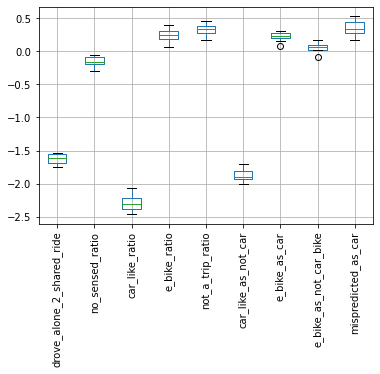

In [80]:
all_estimator_coef.loc[["svm_linear"]].drop(columns=["mispredicted_as_walk", "distance_miles", "non_car_2_car_user_label", "run"]).plot(kind="box", rot=90, grid=True)

### Now that we know that the svm family of estimators works well, let's try some non-linear models as well

In [81]:
estimators = pd.Series({"svm_linear": sksvm.SVR(kernel="linear"), "svm_poly": sksvm.SVR(kernel="poly"), "svm_rbf": sksvm.SVR(kernel="rbf"),
                        "NuSVR_linear": sksvm.NuSVR(kernel="linear"), "NuSVR_poly": sksvm.NuSVR(kernel="poly"), "NuSVR_rbf": sksvm.NuSVR(kernel="rbf")})
std_estimators = estimators.apply(lambda e: skp.Pipeline([("scale", skpr.StandardScaler()), ("reg", e)]))
split_results = get_split_results(split_reps[0])
training_set = split_results.sample(frac=0.8)
test_set = split_results.drop(labels=training_set.index)
fitted_estimators = std_estimators.apply(lambda e: e.fit(training_set[IND_VAR], training_set[DEP_VAR]))
scores = fitted_estimators.apply(lambda e: e.score(test_set[IND_VAR], test_set[DEP_VAR]))
# coef = fitted_estimators[["svm_linear", "NuSVR_linear"]].apply(lambda e: e.coef_)

In [82]:
pd.DataFrame().append(scores, ignore_index=True)

,NuSVR_linear,NuSVR_poly,NuSVR_rbf,svm_linear,svm_poly,svm_rbf
0,0.907667,0.669886,0.749157,0.912168,0.657321,0.759697


In [83]:
# len(coef.loc["svm_linear"].flatten()), len(IND_VAR)

In [84]:
fold5 = skm.KFold()

all_svm_kernel_scores = pd.DataFrame()

for run, split in enumerate(split_reps):
    print(f"About to run manual k-fold validation for run {run}")
    estimators = pd.Series({"svm_linear": sksvm.SVR(kernel="linear"), "svm_poly": sksvm.SVR(kernel="poly"), "svm_rbf": sksvm.SVR(kernel="rbf"),
                        "NuSVR_linear": sksvm.NuSVR(kernel="linear"), "NuSVR_poly": sksvm.NuSVR(kernel="poly"), "NuSVR_rbf": sksvm.NuSVR(kernel="rbf")})
    std_estimators = estimators.apply(lambda e: skp.Pipeline([("scale", skpr.StandardScaler()), ("reg", e)]))
    print(f"Finished creating estimators for run {run}, about to featurize")
    split_results = get_split_results(split)
    print(f"Finished featurizing for run {run}, about to run cross-validation")
    for train_index, test_index in fold5.split(split_results):
        print(f"Split features into training {len(train_index)} and test {len(test_index)}")
        training_set = split_results.loc[train_index]
        test_set = split_results.loc[test_index]
        fitted_estimators = std_estimators.apply(lambda e: e.fit(training_set[IND_VAR], training_set[DEP_VAR]))
        scores = fitted_estimators.apply(lambda e: e.score(test_set[IND_VAR], test_set[DEP_VAR]))
        all_svm_kernel_scores = all_svm_kernel_scores.append(scores, ignore_index=True)

About to run manual k-fold validation for run 0
Finished creating estimators for run 0, about to featurize
Finished featurizing for run 0, about to run cross-validation
Split features into training 400 and test 100
Split features into training 400 and test 100
Split features into training 400 and test 100
Split features into training 400 and test 100
Split features into training 400 and test 100
About to run manual k-fold validation for run 1
Finished creating estimators for run 1, about to featurize
Finished featurizing for run 1, about to run cross-validation
Split features into training 400 and test 100
Split features into training 400 and test 100
Split features into training 400 and test 100
Split features into training 400 and test 100
Split features into training 400 and test 100
About to run manual k-fold validation for run 2
Finished creating estimators for run 2, about to featurize
Finished featurizing for run 2, about to run cross-validation
Split features into training 400 

In [85]:
all_svm_kernel_scores.head()

,NuSVR_linear,NuSVR_poly,NuSVR_rbf,svm_linear,svm_poly,svm_rbf
0,0.877736,0.710284,0.796631,0.876896,0.713086,0.801947
1,0.908161,0.701228,0.758303,0.905203,0.683059,0.769963
2,0.904228,0.731064,0.810389,0.907303,0.702546,0.818236
3,0.900631,0.733220,0.775194,0.904001,0.703920,0.780194
4,0.878167,0.652095,0.774013,0.881265,0.625706,0.778681


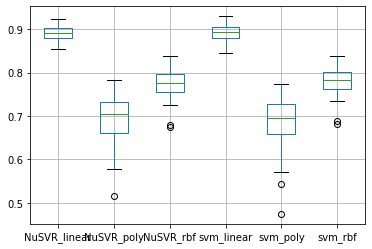

In [86]:
all_svm_kernel_scores.plot(kind="box", grid=True)

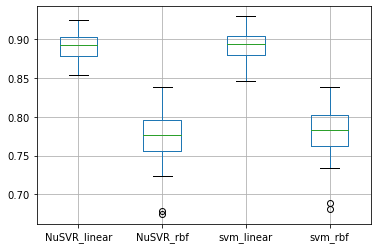

In [87]:
all_svm_kernel_scores.drop(columns=["NuSVR_poly", "svm_poly"]).plot(kind="box", grid=True)

## Tune the final estimator and then apply it to the individual programs

I was going to apply it to the coefficients from this prior estimation, but it turns out that `GridSearchCV` makes it easier. It has a `best_estimator_` field and we can just apply the programs to the estimator.

In [88]:
IND_VAR_OVER_HALF = IND_VAR.copy()
IND_VAR_OVER_HALF.remove("e_bike_as_not_car_bike")
IND_VAR_OVER_HALF.remove("distance_miles")

IND_VAR_PERFECT_10 = ["drove_alone_2_shared_ride", "car_like_ratio", "car_like_as_not_car", "e_bike_as_car", "non_car_2_car_user_label", "mispredicted_as_walk"]

In [89]:
parameters = {'svm__kernel': ('linear', 'rbf', 'sigmoid'), 'svm__C':[1, 10, 100], 'svm__gamma': ('scale', 'auto')}
svr = skp.Pipeline([("scaler", skpr.StandardScaler()), ("svm", sksvm.SVR(kernel='linear'))])
clf = skm.GridSearchCV(svr, parameters, verbose=2)
split_results = get_split_results(split_reps[0])
clf.fit(split_results[IND_VAR], split_results[DEP_VAR])

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END .....svm__C=1, svm__gamma=scale, svm__kernel=linear; total time=   0.0s
[CV] END .....svm__C=1, svm__gamma=scale, svm__kernel=linear; total time=   0.0s
[CV] END .....svm__C=1, svm__gamma=scale, svm__kernel=linear; total time=   0.0s
[CV] END .....svm__C=1, svm__gamma=scale, svm__kernel=linear; total time=   0.0s
[CV] END .....svm__C=1, svm__gamma=scale, svm__kernel=linear; total time=   0.0s
[CV] END ........svm__C=1, svm__gamma=scale, svm__kernel=rbf; total time=   0.0s
[CV] END ........svm__C=1, svm__gamma=scale, svm__kernel=rbf; total time=   0.0s
[CV] END ........svm__C=1, svm__gamma=scale, svm__kernel=rbf; total time=   0.0s
[CV] END ........svm__C=1, svm__gamma=scale, svm__kernel=rbf; total time=   0.0s
[CV] END ........svm__C=1, svm__gamma=scale, svm__kernel=rbf; total time=   0.0s
[CV] END ....svm__C=1, svm__gamma=scale, svm__kernel=sigmoid; total time=   0.0s
[CV] END ....svm__C=1, svm__gamma=scale, svm__ke

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svm', SVR(kernel='linear'))]),
             param_grid={'svm__C': [1, 10, 100],
                         'svm__gamma': ('scale', 'auto'),
                         'svm__kernel': ('linear', 'rbf', 'sigmoid')},
             verbose=2)

In [90]:
all_feature_check_results = pd.DataFrame(clf.cv_results_); all_feature_check_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_svm__C,param_svm__gamma,param_svm__kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.019345,0.000730,0.002951,0.000495,1,scale,linear,"{'svm__C': 1, 'svm__gamma': 'scale', 'svm__ker...",0.876896,0.905203,0.907303,0.904001,0.881265,0.894934,0.013060,5
1,0.012595,0.000439,0.005668,0.000308,1,scale,rbf,"{'svm__C': 1, 'svm__gamma': 'scale', 'svm__ker...",0.801947,0.769963,0.818236,0.780194,0.778681,0.789804,0.017695,9
2,0.013445,0.000401,0.003430,0.000103,1,scale,sigmoid,"{'svm__C': 1, 'svm__gamma': 'scale', 'svm__ker...",0.323459,0.313838,0.169103,0.243619,0.234077,0.256819,0.056706,13
3,0.019968,0.000541,0.002879,0.000135,1,auto,linear,"{'svm__C': 1, 'svm__gamma': 'auto', 'svm__kern...",0.876896,0.905203,0.907303,0.904001,0.881265,0.894934,0.013060,5
4,0.013627,0.000812,0.006040,0.000373,1,auto,rbf,"{'svm__C': 1, 'svm__gamma': 'auto', 'svm__kern...",0.801947,0.769963,0.818236,0.780194,0.778681,0.789804,0.017695,9


[Text(0, 0, "{'svm__C': 1, 'svm__gamma': 'scale', 'svm__kernel': 'linear'}"),
 Text(0, 0, "{'svm__C': 1, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}"),
 Text(0, 0, "{'svm__C': 1, 'svm__gamma': 'scale', 'svm__kernel': 'sigmoid'}"),
 Text(0, 0, "{'svm__C': 1, 'svm__gamma': 'auto', 'svm__kernel': 'linear'}"),
 Text(0, 0, "{'svm__C': 1, 'svm__gamma': 'auto', 'svm__kernel': 'rbf'}"),
 Text(0, 0, "{'svm__C': 1, 'svm__gamma': 'auto', 'svm__kernel': 'sigmoid'}"),
 Text(0, 0, "{'svm__C': 10, 'svm__gamma': 'scale', 'svm__kernel': 'linear'}"),
 Text(0, 0, "{'svm__C': 10, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}"),
 Text(0, 0, "{'svm__C': 10, 'svm__gamma': 'scale', 'svm__kernel': 'sigmoid'}"),
 Text(0, 0, "{'svm__C': 10, 'svm__gamma': 'auto', 'svm__kernel': 'linear'}"),
 Text(0, 0, "{'svm__C': 10, 'svm__gamma': 'auto', 'svm__kernel': 'rbf'}"),
 Text(0, 0, "{'svm__C': 10, 'svm__gamma': 'auto', 'svm__kernel': 'sigmoid'}"),
 Text(0, 0, "{'svm__C': 100, 'svm__gamma': 'scale', 'svm__kernel': 'line

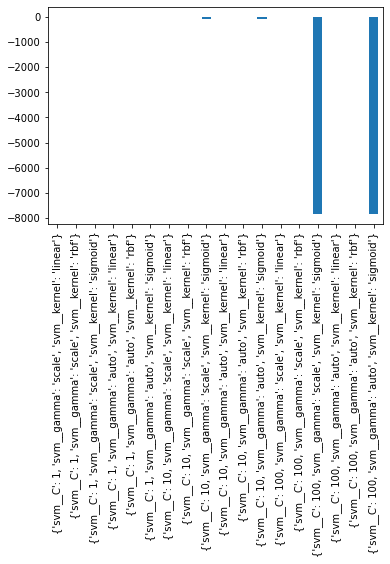

In [91]:
ax = all_feature_check_results.mean_test_score.plot(kind="bar")
ax.set_xticklabels(all_feature_check_results.params.tolist())

In [92]:
all_feature_check_results.query("mean_test_score > -10")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_svm__C,param_svm__gamma,param_svm__kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.019345,0.000730,0.002951,0.000495,1,scale,linear,"{'svm__C': 1, 'svm__gamma': 'scale', 'svm__ker...",0.876896,0.905203,0.907303,0.904001,0.881265,0.894934,0.013060,5
1,0.012595,0.000439,0.005668,0.000308,1,scale,rbf,"{'svm__C': 1, 'svm__gamma': 'scale', 'svm__ker...",0.801947,0.769963,0.818236,0.780194,0.778681,0.789804,0.017695,9
2,0.013445,0.000401,0.003430,0.000103,1,scale,sigmoid,"{'svm__C': 1, 'svm__gamma': 'scale', 'svm__ker...",0.323459,0.313838,0.169103,0.243619,0.234077,0.256819,0.056706,13
3,0.019968,0.000541,0.002879,0.000135,1,auto,linear,"{'svm__C': 1, 'svm__gamma': 'auto', 'svm__kern...",0.876896,0.905203,0.907303,0.904001,0.881265,0.894934,0.013060,5
4,0.013627,0.000812,0.006040,0.000373,1,auto,rbf,"{'svm__C': 1, 'svm__gamma': 'auto', 'svm__kern...",0.801947,0.769963,0.818236,0.780194,0.778681,0.789804,0.017695,9
5,0.013064,0.000356,0.003467,0.000056,1,auto,sigmoid,"{'svm__C': 1, 'svm__gamma': 'auto', 'svm__kern...",0.323459,0.313838,0.169103,0.243619,0.234077,0.256819,0.056706,13
6,0.075916,0.013773,0.002392,0.000200,10,scale,linear,"{'svm__C': 10, 'svm__gamma': 'scale', 'svm__ke...",0.876749,0.906381,0.906872,0.903670,0.881372,0.895009,0.013149,3
7,0.018623,0.001720,0.005244,0.000645,10,scale,rbf,"{'svm__C': 10, 'svm__gamma': 'scale', 'svm__ke...",0.827179,0.850111,0.839397,0.851825,0.774547,0.828612,0.028434,7
9,0.077275,0.013443,0.003052,0.000893,10,auto,linear,"{'svm__C': 10, 'svm__gamma': 'auto', 'svm__ker...",0.876749,0.906381,0.906872,0.903670,0.881372,0.895009,0.013149,3
10,0.019045,0.001539,0.004883,0.000145,10,auto,rbf,"{'svm__C': 10, 'svm__gamma': 'auto', 'svm__ker...",0.827179,0.850111,0.839397,0.851825,0.774547,0.828612,0.028434,7


[Text(0, 0, "{'svm__C': 1, 'svm__gamma': 'scale', 'svm__kernel': 'linear'}"),
 Text(0, 0, "{'svm__C': 1, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}"),
 Text(0, 0, "{'svm__C': 1, 'svm__gamma': 'scale', 'svm__kernel': 'sigmoid'}"),
 Text(0, 0, "{'svm__C': 1, 'svm__gamma': 'auto', 'svm__kernel': 'linear'}"),
 Text(0, 0, "{'svm__C': 1, 'svm__gamma': 'auto', 'svm__kernel': 'rbf'}"),
 Text(0, 0, "{'svm__C': 1, 'svm__gamma': 'auto', 'svm__kernel': 'sigmoid'}"),
 Text(0, 0, "{'svm__C': 10, 'svm__gamma': 'scale', 'svm__kernel': 'linear'}"),
 Text(0, 0, "{'svm__C': 10, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}"),
 Text(0, 0, "{'svm__C': 10, 'svm__gamma': 'auto', 'svm__kernel': 'linear'}"),
 Text(0, 0, "{'svm__C': 10, 'svm__gamma': 'auto', 'svm__kernel': 'rbf'}"),
 Text(0, 0, "{'svm__C': 100, 'svm__gamma': 'scale', 'svm__kernel': 'linear'}"),
 Text(0, 0, "{'svm__C': 100, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}"),
 Text(0, 0, "{'svm__C': 100, 'svm__gamma': 'auto', 'svm__kernel': 'linear'

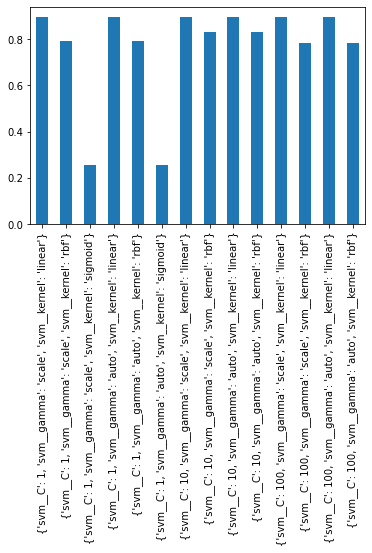

In [93]:
ax = all_feature_check_results.query("mean_test_score >= -10").mean_test_score.plot(kind="bar")
ax.set_xticklabels(all_feature_check_results.query("mean_test_score >= -10").params.tolist())

[Text(0, 0, "{'svm__C': 100, 'svm__gamma': 'scale', 'svm__kernel': 'linear'}"),
 Text(0, 0, "{'svm__C': 100, 'svm__gamma': 'auto', 'svm__kernel': 'linear'}")]

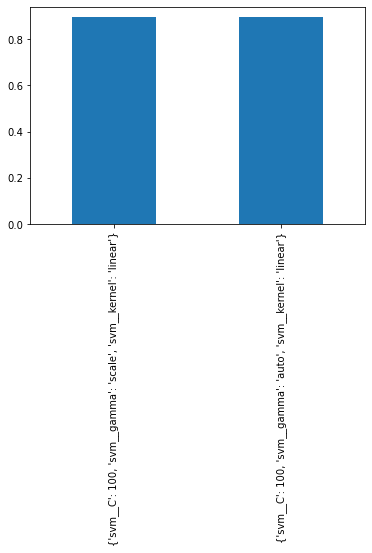

In [94]:
ax = all_feature_check_results.query("rank_test_score == 1").mean_test_score.plot(kind="bar")
ax.set_xticklabels(all_feature_check_results.query("rank_test_score == 1").params.tolist())

In [95]:
parameters = {'svm__kernel': ('linear', 'rbf', 'sigmoid'), 'svm__C':[1, 10, 100], 'svm__gamma': ('scale', 'auto')}
svr = skp.Pipeline([("scaler", skpr.StandardScaler()), ("svm", sksvm.SVR(kernel='linear'))])
clf = skm.GridSearchCV(svr, parameters, verbose=2)
split_results = get_split_results(split_reps[0])
clf.fit(split_results[IND_VAR_OVER_HALF], split_results[DEP_VAR])

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END .....svm__C=1, svm__gamma=scale, svm__kernel=linear; total time=   0.0s
[CV] END .....svm__C=1, svm__gamma=scale, svm__kernel=linear; total time=   0.0s
[CV] END .....svm__C=1, svm__gamma=scale, svm__kernel=linear; total time=   0.0s
[CV] END .....svm__C=1, svm__gamma=scale, svm__kernel=linear; total time=   0.0s
[CV] END .....svm__C=1, svm__gamma=scale, svm__kernel=linear; total time=   0.0s
[CV] END ........svm__C=1, svm__gamma=scale, svm__kernel=rbf; total time=   0.0s
[CV] END ........svm__C=1, svm__gamma=scale, svm__kernel=rbf; total time=   0.0s
[CV] END ........svm__C=1, svm__gamma=scale, svm__kernel=rbf; total time=   0.0s
[CV] END ........svm__C=1, svm__gamma=scale, svm__kernel=rbf; total time=   0.0s
[CV] END ........svm__C=1, svm__gamma=scale, svm__kernel=rbf; total time=   0.0s
[CV] END ....svm__C=1, svm__gamma=scale, svm__kernel=sigmoid; total time=   0.0s
[CV] END ....svm__C=1, svm__gamma=scale, svm__ke

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svm', SVR(kernel='linear'))]),
             param_grid={'svm__C': [1, 10, 100],
                         'svm__gamma': ('scale', 'auto'),
                         'svm__kernel': ('linear', 'rbf', 'sigmoid')},
             verbose=2)

In [96]:
over_half_feature_check_results = pd.DataFrame(clf.cv_results_); over_half_feature_check_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_svm__C,param_svm__gamma,param_svm__kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.015656,0.001224,0.002497,0.000154,1,scale,linear,"{'svm__C': 1, 'svm__gamma': 'scale', 'svm__ker...",0.876816,0.905777,0.906671,0.903920,0.882539,0.895145,0.012788,5
1,0.012216,0.000237,0.005565,0.000465,1,scale,rbf,"{'svm__C': 1, 'svm__gamma': 'scale', 'svm__ker...",0.794736,0.755681,0.814021,0.786216,0.781403,0.786411,0.018979,11
2,0.012479,0.000478,0.003054,0.000328,1,scale,sigmoid,"{'svm__C': 1, 'svm__gamma': 'scale', 'svm__ker...",0.419395,0.323105,0.348864,0.379683,0.239751,0.342160,0.060447,13
3,0.017344,0.000952,0.002715,0.000203,1,auto,linear,"{'svm__C': 1, 'svm__gamma': 'auto', 'svm__kern...",0.876816,0.905777,0.906671,0.903920,0.882539,0.895145,0.012788,5
4,0.011973,0.000335,0.005417,0.000188,1,auto,rbf,"{'svm__C': 1, 'svm__gamma': 'auto', 'svm__kern...",0.794736,0.755681,0.814021,0.786216,0.781403,0.786411,0.018979,11


[Text(0, 0, "{'svm__C': 100, 'svm__gamma': 'scale', 'svm__kernel': 'linear'}"),
 Text(0, 0, "{'svm__C': 100, 'svm__gamma': 'auto', 'svm__kernel': 'linear'}")]

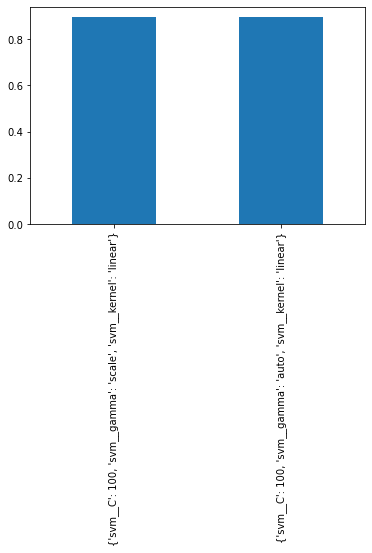

In [97]:
ax = over_half_feature_check_results.query("rank_test_score == 1").mean_test_score.plot(kind="bar")
ax.set_xticklabels(over_half_feature_check_results.query("rank_test_score == 1").params.tolist())

In [98]:
parameters = {'svm__kernel': ('linear', 'rbf', 'sigmoid'), 'svm__C':[1, 10, 30], 'svm__gamma': ('scale', 'auto')}
svr = skp.Pipeline([("scaler", skpr.StandardScaler()), ("svm", sksvm.SVR(kernel='linear'))])
clf = skm.GridSearchCV(svr, parameters, verbose=2)
split_results = get_split_results(split_reps[0])
clf.fit(split_results[IND_VAR_PERFECT_10], split_results[DEP_VAR])

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END .....svm__C=1, svm__gamma=scale, svm__kernel=linear; total time=   0.0s
[CV] END .....svm__C=1, svm__gamma=scale, svm__kernel=linear; total time=   0.0s
[CV] END .....svm__C=1, svm__gamma=scale, svm__kernel=linear; total time=   0.0s
[CV] END .....svm__C=1, svm__gamma=scale, svm__kernel=linear; total time=   0.0s
[CV] END .....svm__C=1, svm__gamma=scale, svm__kernel=linear; total time=   0.0s
[CV] END ........svm__C=1, svm__gamma=scale, svm__kernel=rbf; total time=   0.0s
[CV] END ........svm__C=1, svm__gamma=scale, svm__kernel=rbf; total time=   0.0s
[CV] END ........svm__C=1, svm__gamma=scale, svm__kernel=rbf; total time=   0.0s
[CV] END ........svm__C=1, svm__gamma=scale, svm__kernel=rbf; total time=   0.0s
[CV] END ........svm__C=1, svm__gamma=scale, svm__kernel=rbf; total time=   0.0s
[CV] END ....svm__C=1, svm__gamma=scale, svm__kernel=sigmoid; total time=   0.0s
[CV] END ....svm__C=1, svm__gamma=scale, svm__ke

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svm', SVR(kernel='linear'))]),
             param_grid={'svm__C': [1, 10, 30], 'svm__gamma': ('scale', 'auto'),
                         'svm__kernel': ('linear', 'rbf', 'sigmoid')},
             verbose=2)

In [99]:
perfect_10_feature_check_results = pd.DataFrame(clf.cv_results_); perfect_10_feature_check_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_svm__C,param_svm__gamma,param_svm__kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.013138,0.001101,0.002141,0.000217,1,scale,linear,"{'svm__C': 1, 'svm__gamma': 'scale', 'svm__ker...",0.869436,0.885545,0.885591,0.881208,0.836324,0.871621,0.018610,5
1,0.010910,0.001539,0.004686,0.000278,1,scale,rbf,"{'svm__C': 1, 'svm__gamma': 'scale', 'svm__ker...",0.791796,0.743612,0.798952,0.789440,0.771165,0.778993,0.019922,11
2,0.010335,0.000631,0.002540,0.000134,1,scale,sigmoid,"{'svm__C': 1, 'svm__gamma': 'scale', 'svm__ker...",-0.463216,-1.397857,-0.208752,-0.527061,-0.654686,-0.650314,0.401002,14
3,0.012426,0.001232,0.002401,0.000354,1,auto,linear,"{'svm__C': 1, 'svm__gamma': 'auto', 'svm__kern...",0.869436,0.885545,0.885591,0.881208,0.836324,0.871621,0.018610,5
4,0.010941,0.001165,0.005238,0.000252,1,auto,rbf,"{'svm__C': 1, 'svm__gamma': 'auto', 'svm__kern...",0.791796,0.743612,0.798952,0.789440,0.771165,0.778993,0.019922,11


[Text(0, 0, "{'svm__C': 10, 'svm__gamma': 'scale', 'svm__kernel': 'linear'}"),
 Text(0, 0, "{'svm__C': 10, 'svm__gamma': 'auto', 'svm__kernel': 'linear'}")]

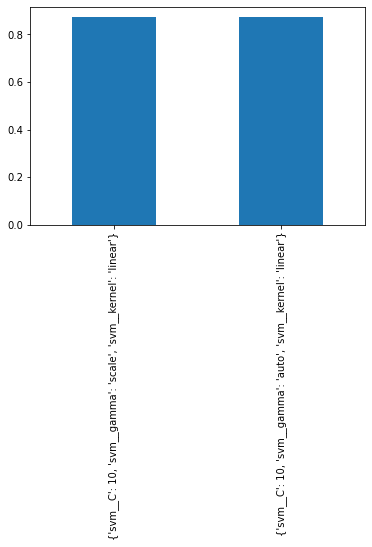

In [100]:
ax = perfect_10_feature_check_results.query("rank_test_score == 1").mean_test_score.plot(kind="bar")
ax.set_xticklabels(perfect_10_feature_check_results.query("rank_test_score == 1").params.tolist())

In [101]:
pd.Series(clf.best_estimator_['svm'].coef_.flatten(), index=IND_VAR_PERFECT_10)

drove_alone_2_shared_ride   -1.375558
car_like_ratio              -2.110444
car_like_as_not_car         -2.007813
e_bike_as_car                0.492697
non_car_2_car_user_label    -0.480350
mispredicted_as_walk         0.688988
dtype: float64

## Final retraining, picking the split that resulted in the median and dropping unimportant features

In [102]:
# Let's find the split which resulted in the median value for svm_linear
print(all_svm_kernel_scores.svm_linear.median(), all_svm_kernel_scores.svm_linear.quantile(interpolation="nearest"))
median_row = all_svm_kernel_scores[all_svm_kernel_scores.svm_linear == all_svm_kernel_scores.svm_linear.quantile(interpolation="nearest")]
median_index = median_row.index.tolist()[0]
print(median_index)

0.8934769518370469 0.8916646714209431
31


In [103]:
split_reps_indices = np.split(np.array(range(0,len(all_svm_kernel_scores))), len(split_reps))
for i, sri in enumerate(split_reps_indices):
    if median_index in sri:
        median_split_reps_index = i
        
print(median_split_reps_index)

6


In [114]:
concat_split_results = None
for splits in split_reps:
    curr_split_results = get_split_results(splits)
    concat_split_results = curr_split_results if concat_split_results is None else concat_split_results.append(curr_split_results)

In [115]:
len(concat_split_results)

5000

In [116]:
IND_VAR_FINAL = IND_VAR_OVER_HALF
parameters = {'svm__C':range(1, 20, 2), 'svm__gamma': ('scale', 'auto')}
svr = skp.Pipeline([("scaler", skpr.StandardScaler()), ("svm", sksvm.SVR(kernel='linear'))])
clf = skm.GridSearchCV(svr, parameters, verbose=2)
# split_results = get_split_results(split_reps[median_split_reps_index])
clf.fit(concat_split_results[IND_VAR_FINAL], concat_split_results[DEP_VAR])

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END .........................svm__C=1, svm__gamma=scale; total time=   1.1s
[CV] END .........................svm__C=1, svm__gamma=scale; total time=   1.1s
[CV] END .........................svm__C=1, svm__gamma=scale; total time=   1.1s
[CV] END .........................svm__C=1, svm__gamma=scale; total time=   1.1s
[CV] END .........................svm__C=1, svm__gamma=scale; total time=   1.1s
[CV] END ..........................svm__C=1, svm__gamma=auto; total time=   1.1s
[CV] END ..........................svm__C=1, svm__gamma=auto; total time=   1.0s
[CV] END ..........................svm__C=1, svm__gamma=auto; total time=   1.0s
[CV] END ..........................svm__C=1, svm__gamma=auto; total time=   1.1s
[CV] END ..........................svm__C=1, svm__gamma=auto; total time=   1.1s
[CV] END .........................svm__C=3, svm__gamma=scale; total time=   1.8s
[CV] END .........................svm__C=3, svm

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svm', SVR(kernel='linear'))]),
             param_grid={'svm__C': range(1, 20, 2),
                         'svm__gamma': ('scale', 'auto')},
             verbose=2)

In [117]:
second_check_results = pd.DataFrame(clf.cv_results_); second_check_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_svm__C,param_svm__gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.029572,0.021167,0.082044,0.003986,1,scale,"{'svm__C': 1, 'svm__gamma': 'scale'}",0.891602,0.900929,0.887089,0.902275,0.893595,0.895098,0.005730,19
1,0.991252,0.033430,0.077401,0.002416,1,auto,"{'svm__C': 1, 'svm__gamma': 'auto'}",0.891602,0.900929,0.887089,0.902275,0.893595,0.895098,0.005730,19
2,1.754924,0.097824,0.077614,0.002996,3,scale,"{'svm__C': 3, 'svm__gamma': 'scale'}",0.891599,0.900933,0.887116,0.902275,0.893616,0.895108,0.005722,9
3,1.802982,0.085481,0.081022,0.006472,3,auto,"{'svm__C': 3, 'svm__gamma': 'auto'}",0.891599,0.900933,0.887116,0.902275,0.893616,0.895108,0.005722,9
4,2.603897,0.187480,0.081807,0.002817,5,scale,"{'svm__C': 5, 'svm__gamma': 'scale'}",0.891601,0.900938,0.887116,0.902277,0.893621,0.895111,0.005723,1


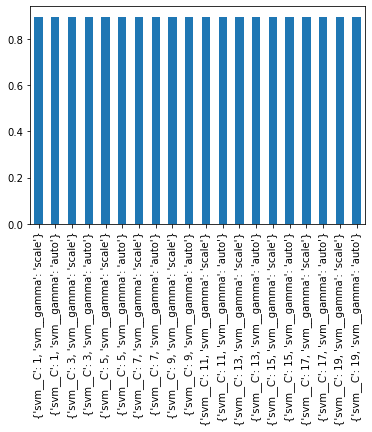

In [118]:
ax = second_check_results.mean_test_score.plot(kind="bar")
ax.set_xticklabels(second_check_results.params.tolist())
ax

In [119]:
clf.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm', SVR(C=5, kernel='linear'))])

## Now, let's create splits for the actual programs

In [108]:
program_specific_splits_series = energy_consumption_df.groupby("program").apply(lambda g: g.index)

In [109]:
program_specific_split_results = get_split_results(program_specific_splits_series.values).set_index(program_specific_splits_series.index)

In [110]:
program_specific_split_results

,count,error_for_confusion,error_for_prediction,expected,predicted,user_labeled,distance_miles,distance,duration,drove_alone_2_shared_ride,...,not_a_trip_ratio,car_like_as_not_car,e_bike_as_car,e_bike_as_not_car_bike,non_car_2_car_user_label,non_car_2_car_sensed,mispredicted_as_walk,mispredicted_as_car,error_pct_for_confusion,error_pct_for_prediction
program,,,,,,,,,,,,,,,,,,,,,
4c,4376,-1330.012429,-147.023206,17461.178436,18644.167658,18791.190864,23030.698160,3.706433e+07,7.394717e+06,0.512937,...,0.018622,0.316129,0.489554,0.241317,0.086751,0.000000,0.172252,0.156204,-7.077851,-0.782405
cc,19512,5104.612883,13588.260963,102889.455304,111373.103384,97784.842421,122649.880106,1.973859e+08,3.552808e+07,0.526490,...,0.008728,0.188122,0.388610,0.238429,0.073825,0.004326,0.140094,0.115629,5.220250,13.896081
fc,7852,3189.660125,3484.401105,26368.567353,26663.308333,23178.907228,29659.371344,4.773215e+07,1.305504e+07,0.713377,...,0.092853,0.141791,0.204502,0.273896,0.020881,0.023017,0.093542,0.118793,13.761046,15.032638
pc,11250,11741.268537,14816.039219,65859.192460,68933.963142,54117.923923,63775.280833,1.026364e+08,1.709491e+07,0.712523,...,0.077384,0.095392,0.628665,0.152343,0.007710,0.000648,0.071555,0.193039,21.695711,27.377324
prepilot,2425,1973.804010,2204.543292,13027.151920,13257.891202,11053.347910,13332.567666,2.145669e+07,3.908042e+06,0.667137,...,0.001498,0.107095,0.574215,0.230597,0.120421,0.027886,0.069354,0.247183,17.857069,19.944575
sc,5317,2990.533934,2255.085397,25574.470261,24839.021724,22583.936327,24317.503729,3.913524e+07,7.071397e+06,0.565912,...,0.013332,0.080367,0.396300,0.153008,0.016455,0.013254,0.051847,0.062226,13.241863,9.985351
stage,7252,-614.820861,2170.793662,50159.224985,52944.839509,50774.045846,56228.727347,9.049139e+07,1.446974e+07,0.665754,...,0.001892,0.125201,0.174837,0.250719,0.055007,0.020005,0.061393,0.038735,-1.210896,4.275400
vail,2038,-1396.389659,-711.871762,9447.404428,10131.922325,10843.794087,10538.761656,1.696050e+07,3.595588e+06,0.833338,...,0.037234,0.211891,0.353778,0.220490,0.079382,0.007013,0.097609,0.091614,-12.877316,-6.564785


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8917cd06d0>,
      dtype=object)

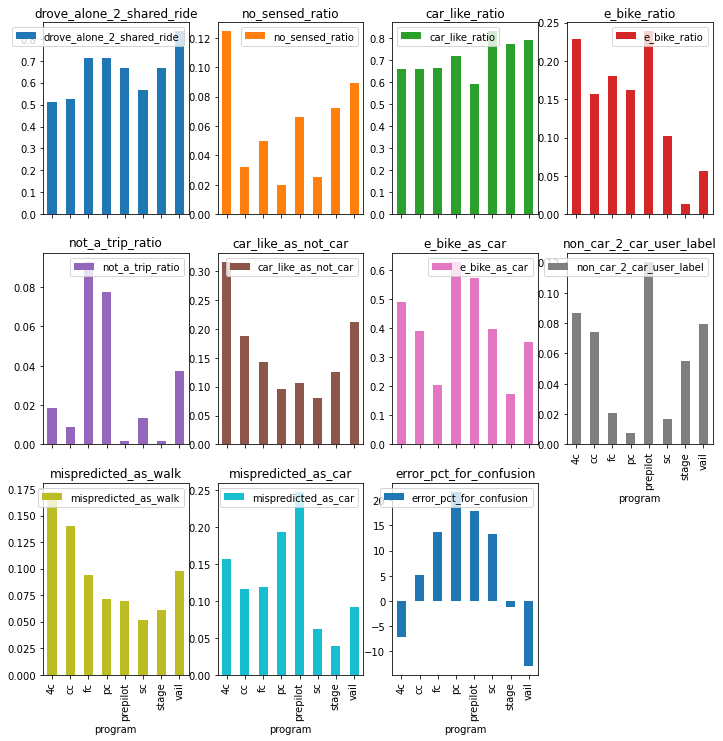

In [111]:
program_specific_split_results[IND_VAR_FINAL+[DEP_VAR]].plot(kind="bar", subplots=True, layout=(3,4), sharex=True, figsize=(12, 12))

In [120]:
program_specific_split_results["predicted_error_pct_for_confusion"] = clf.predict(program_specific_split_results[IND_VAR_FINAL])

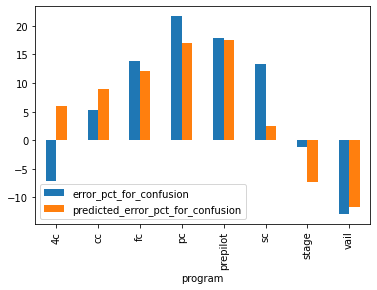

In [121]:
program_specific_split_results[["error_pct_for_confusion", "predicted_error_pct_for_confusion"]].plot(kind="bar")

In [122]:
clf.score(program_specific_split_results[IND_VAR_FINAL], program_specific_split_results[DEP_VAR])

0.6610239359816578

In [123]:
pd.Series(clf.best_estimator_['svm'].coef_.flatten(), index=IND_VAR_FINAL)

drove_alone_2_shared_ride   -1.638917
no_sensed_ratio             -0.160706
car_like_ratio              -2.274563
e_bike_ratio                 0.271474
not_a_trip_ratio             0.312830
car_like_as_not_car         -1.895583
e_bike_as_car                0.217449
non_car_2_car_user_label    -0.572478
mispredicted_as_walk         0.830234
mispredicted_as_car          0.342224
dtype: float64

In [ ]:
split_results[["drove_alone_2_shared_ride", "no_sensed_ratio", "not_a_trip_ratio", "mispredicted_as_walk"]].plot(subplots=True, layout=(2,2), figsize=(6,6), sharex=True)

In [ ]:
pd.Series(clf.best_estimator_.coef_.flatten(), index=IND_VAR_FINAL) * program_specific_split_results[IND_VAR_FINAL].loc["4c"]

In [ ]:
pd.Series(clf.best_estimator_.coef_.flatten(), index=IND_VAR_FINAL) * program_specific_split_results[IND_VAR_FINAL].loc["prepilot"]

In [ ]:
pd.Series(clf.best_estimator_.coef_.flatten(), index=IND_VAR_FINAL) * program_specific_split_results[IND_VAR_FINAL].loc["vail"]

In [ ]:
energy_consumption_df.query('program == "4c"').groupby("mode_confirm").sum().error_for_confusion.abs().sort_values().tail(n=10)

In [ ]:
energy_consumption_df.query('program == "prepilot"').groupby("mode_confirm").sum().error_for_confusion.abs().sort_values().tail(n=10)

In [ ]:
ax = energy_consumption_df.query('program == "4c" & (mode_confirm == "pilot_ebike" | mode_confirm == "drove_alone" | mode_confirm == "shared_ride")').groupby('mode_confirm').sum()[["expected", "user_labeled"]].plot(kind="bar")

In [ ]:
ax = energy_consumption_df.query('program == "prepilot" & (mode_confirm == "pilot_ebike" | mode_confirm == "drove_alone" | mode_confirm == "shared_ride")').groupby('mode_confirm').sum()[["expected", "user_labeled"]].plot(kind="bar")

In [ ]:
energy_consumption_df.query('program == "4c"').groupby("mode_confirm").sum()['distance_miles'].sort_values().tail(n=10)

In [ ]:
energy_consumption_df.query('program == "prepilot"').groupby("mode_confirm").sum()['distance_miles'].sort_values().tail(n=10)

In [ ]:
ax = energy_consumption_df.query('program == "4c" & (mode_confirm == "pilot_ebike" | mode_confirm == "drove_alone" | mode_confirm == "shared_ride")').groupby(['mode_confirm', 'primary_mode']).sum()[["expected", "user_labeled"]].plot(kind="bar")
ax1 = energy_consumption_df.query('program == "4c" & (mode_confirm == "pilot_ebike" | mode_confirm == "drove_alone" | mode_confirm == "shared_ride")').groupby(['mode_confirm', 'primary_mode']).sum()[["error_for_confusion"]].plot(kind="bar")
ax, ax1

In [ ]:
user_label_ec_4c = energy_consumption_df.query('program == "4c"').user_labeled.sum(); user_label_ec_4c
user_label_ec_prepilot = energy_consumption_df.query('program == "prepilot"').user_labeled.sum(); user_label_ec_prepilot

In [ ]:
energy_consumption_df.query('program == "4c" & (mode_confirm == "pilot_ebike" | mode_confirm == "drove_alone" | mode_confirm == "shared_ride")').groupby(['mode_confirm', 'primary_mode']).sum()[["expected", "user_labeled", "error_for_confusion"]] / user_label_ec_4c

In [ ]:
energy_consumption_df.query('program == "prepilot" & (mode_confirm == "pilot_ebike" | mode_confirm == "drove_alone" | mode_confirm == "shared_ride")').groupby(['mode_confirm', 'primary_mode']).sum()[["expected", "user_labeled", "error_for_confusion"]] / user_label_ec_prepilot

In [ ]:
ax = energy_consumption_df.query('program == "prepilot" & (mode_confirm == "pilot_ebike" | mode_confirm == "drove_alone" | mode_confirm == "shared_ride")').groupby(['mode_confirm', 'primary_mode']).sum()[["expected", "user_labeled"]].plot(kind="bar")

In [ ]:
ax = energy_consumption_df.query('program == "vail" & (mode_confirm == "pilot_ebike" | mode_confirm == "drove_alone" | mode_confirm == "shared_ride")').groupby(['mode_confirm', 'primary_mode']).sum()[["expected", "user_labeled"]].plot(kind="bar")

In [ ]:
energy_consumption_df.query('program == "vail" & (mode_confirm == "pilot_ebike" | mode_confirm == "drove_alone" | mode_confirm == "shared_ride")').groupby(['mode_confirm', 'primary_mode']).sum()[["expected", "user_labeled", "error_for_confusion"]] / user_label_ec_prepilot

### Let's bootstrap by creating splits with re-shuffling

Before this, we have splits of 500 x 120, representing 500 fake programs with 120 trips per program
But our actual program sizes are in the 1000s. So let's create programs of 6000 trips each, which is 
If we reshuffle and re-generate 10 times, we will end up with 100 fake programs of 6000 trips each

Let's try to work with that instead

In [ ]:
get_set_splits(n_splits=10)

In [ ]:
large_size_splits = []
for round in range(50):
    large_size_splits.append(get_set_splits(n_splits=10))

In [ ]:
large_size_splits = np.array(large_size_splits).flatten()

In [ ]:
split_results = get_split_results(large_size_splits)

In [ ]:
split_results[["drove_alone_2_shared_ride", "no_sensed_ratio", "not_a_trip_ratio", "mispredicted_as_walk", 'misrepresented_car_like_as_no_sensed', 'non_car_2_car_user_label', 'e_bike_ratio', "car_like_ratio", 'error_pct_for_confusion']].plot(subplots=True, layout=(3,3), figsize=(12,12), sharex=True)

In [ ]:
IND_VAR

In [ ]:
IND_VAR_FINAL = IND_VAR.copy() + ['misrepresented_car_like_as_no_sensed', 'car_like_ratio']
IND_VAR_FINAL.remove('distance_miles')
parameters = {'svm__C':range(1, 30, 2), 'svm__gamma': ('scale', 'auto')}
svr = skp.Pipeline([("scaler", skpr.StandardScaler()), ("svm", sksvm.SVR(kernel='linear'))])
clf = skm.GridSearchCV(svr, parameters, verbose=2)
split_results = get_split_results(split_reps[median_split_reps_index])
clf.fit(split_results[IND_VAR_FINAL], split_results[DEP_VAR])

In [ ]:
svr.get_params()

In [ ]:
third_check_results = pd.DataFrame(clf.cv_results_); third_check_results.head()

In [ ]:
ax = third_check_results.mean_test_score.plot(kind="bar")
ax.set_xticklabels(third_check_results.params.tolist())
ax

In [ ]:
clf.best_estimator_

In [ ]:
pd.Series(clf.best_estimator_['svm'].coef_.flatten(), index=IND_VAR_FINAL)

In [ ]:
program_specific_split_results = get_split_results(program_specific_splits_series.values).set_index(program_specific_splits_series.index)

In [ ]:
clf.best_estimator_.predict(program_specific_split_results[IND_VAR_FINAL])

In [ ]:
program_specific_split_results["predicted_error_pct_for_confusion"] = clf.best_estimator_.predict(program_specific_split_results[IND_VAR_FINAL])

In [ ]:
program_specific_split_results[["error_pct_for_confusion", "predicted_error_pct_for_confusion"]].plot(kind="bar")

In [ ]:
pd.Series(clf.best_estimator_['svm'].coef_.flatten(), index=IND_VAR_FINAL) * program_specific_split_results[IND_VAR_FINAL].loc["4c"]

In [ ]:
pd.Series(clf.best_estimator_['svm'].coef_.flatten(), index=IND_VAR_FINAL) * program_specific_split_results[IND_VAR_FINAL].loc["vail"]

### Retrying after removing the `mispredicted_as_car` as well

In [ ]:
IND_VAR_FINAL = IND_VAR.copy() + ['misrepresented_car_like_as_no_sensed', 'car_like_ratio']
IND_VAR_FINAL.remove('distance_miles')
IND_VAR_FINAL.remove('mispredicted_as_car')
parameters = {'svm__C':range(7, 30, 2), 'svm__gamma': ('scale', 'auto')}
svr = skp.Pipeline([("scaler", skpr.StandardScaler()), ("svm", sksvm.SVR(kernel='linear'))])
clf = skm.GridSearchCV(svr, parameters, verbose=2)
split_results = get_split_results(split_reps[median_split_reps_index])
clf.fit(split_results[IND_VAR_FINAL], split_results[DEP_VAR])

In [ ]:
fourth_check_results = pd.DataFrame(clf.cv_results_); fourth_check_results.head()

In [ ]:
ax = fourth_check_results.mean_test_score.plot(kind="bar")
ax.set_xticklabels(fourth_check_results.params.tolist())
ax

In [ ]:
clf.best_estimator_.predict(program_specific_split_results[IND_VAR_FINAL])

In [ ]:
program_specific_split_results["predicted_error_pct_for_confusion"] = clf.best_estimator_.predict(program_specific_split_results[IND_VAR_FINAL])

In [ ]:
program_specific_split_results[["error_pct_for_confusion", "predicted_error_pct_for_confusion"]].plot(kind="bar")

In [ ]:
pd.Series(clf.best_estimator_['svm'].coef_.flatten(), index=IND_VAR_FINAL) * program_specific_split_results[IND_VAR_FINAL].loc["4c"]